In [81]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 300

In [ ]:
def UExact(x,y,t,u0,v0,alpha,beta,A,nu):
    u = u0 - A * beta * math.cos(alpha * (x - u0 * t)) * math.sin(beta * (y - v0 * t)) * math.exp(-(alpha ** 2 + beta ** 2) * nu * t);
    return u


In [ ]:
def VExact(x,y,t,u0,v0,alpha,beta,A,nu):
    v = v0 + A * alpha * math.sin(alpha * (x - u0 * t)) * math.cos(beta * (y - v0 * t)) * math.exp(-(alpha ** 2 + beta ** 2) * nu * t);
    return v


In [ ]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [ ]:
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [ ]:
fields = ["x","y","z","velocityy"]

In [ ]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, grid_type, case, f'nx_{grid_size}')
                print(case_dir)

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.r[0:,1,0]
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in ["x","velocityy"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["velocityy"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["velocityy"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return t, df["x"].values, df["velocityy"].values, ds
            

In [ ]:
error_lists = [[[] for j in range(len(grid_types))] for i in range(len(methods))]
df_lists = [[[[] for k in range(len(grid_sizes))] for j in range(len(grid_types))] for i in range(len(methods))]

i_method = -1
for method in methods:
    i_method += 1
    i_grid_type = -1
    for grid_type in grid_types:
        i_grid_type += 1
        i_grid_size = -1
        for grid_size in grid_sizes:
            i_grid_size += 1

            case_dir = os.path.join(root_dir, method, grid_type, wave_number,f'nx_{grid_size}')
            
            # Load plt files
            plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
            
            for idx in range(len(plt_files)):
            
                ds = yt.load(plt_files[idx])
                ray = ds.r[0:,1,0]
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in fields})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]

                df_lists[i_method][i_grid_type][i_grid_size].append(df)
                
            # Plot error
            error_file = os.path.join(case_dir,'ctv.log')
            with open(error_file) as f:
                lines = f.readlines()
                time = [float(line.split()[0]) for line in lines[1:]]
                u_error = [float(line.split()[1]) for line in lines[1:]]
                v_error = [float(line.split()[2]) for line in lines[1:]]
            data={'time':time,'u_error':u_error,'v_error':v_error}
            error_lists[i_method][i_grid_type].append(pd.DataFrame(data)) 


# Case CTV

In [82]:
root_dir = '/Users/dbeckers/ctv'

In [83]:
t_final = 0.5
Lx = 2.0
u0 = 1.0
v0 = 0.0
alpha = 8*math.pi
beta = 8*math.pi
A = 1/(8*math.pi)
nu = 0.001

In [84]:
plt.rcParams["animation.html"] = "jshtml"
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['godunov_weno_z'],['uniform'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes

def animate(i):
    _,_,_,ds = postprocess_dist('8pi',i,root_dir,['godunov_weno_z'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],False,2)
    sliceplot._switch_ds(ds)
    return 

# FuncAnimation(fig, animate, frames=len(plt_files), interval=200)
anim = FuncAnimation(fig, animate, frames=9, interval=200)
anim.save('2-ctv_case.gif',dpi=300)

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


yt : [INFO     ] 2022-08-07 21:13:23,367 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:13:23,384 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:13:23,397 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:13:23,413 Parameters: domain_right_edge         = [2.        2.        0.0078125]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: Visib

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:27,273 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:29,084 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:32,664 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:35,933 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:39,983 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:13:44,230 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:15,361 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:20,194 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:24,831 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:29,919 Making a fixed reso

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:34,265 Making a fixed reso

# Uniform

### Initial timestep

In [85]:
lw_exact = 0.5
ls_exact = 'dashed'

In [86]:
_,_,_,ds = postprocess_dist('8pi',0,root_dir,['godunov_weno_z'],['uniform'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('11a-ctv_uniform_final_godunov_ppm_initial_slice.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:14:40,513 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:14:40,515 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:14:40,520 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:14:40,524 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:14:41,851 xlim = 0.000000 2.0

yt : [INFO     ] 2022-08-07 21:14:44,236 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:14:44,238 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:14:44,243 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:14:44,247 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


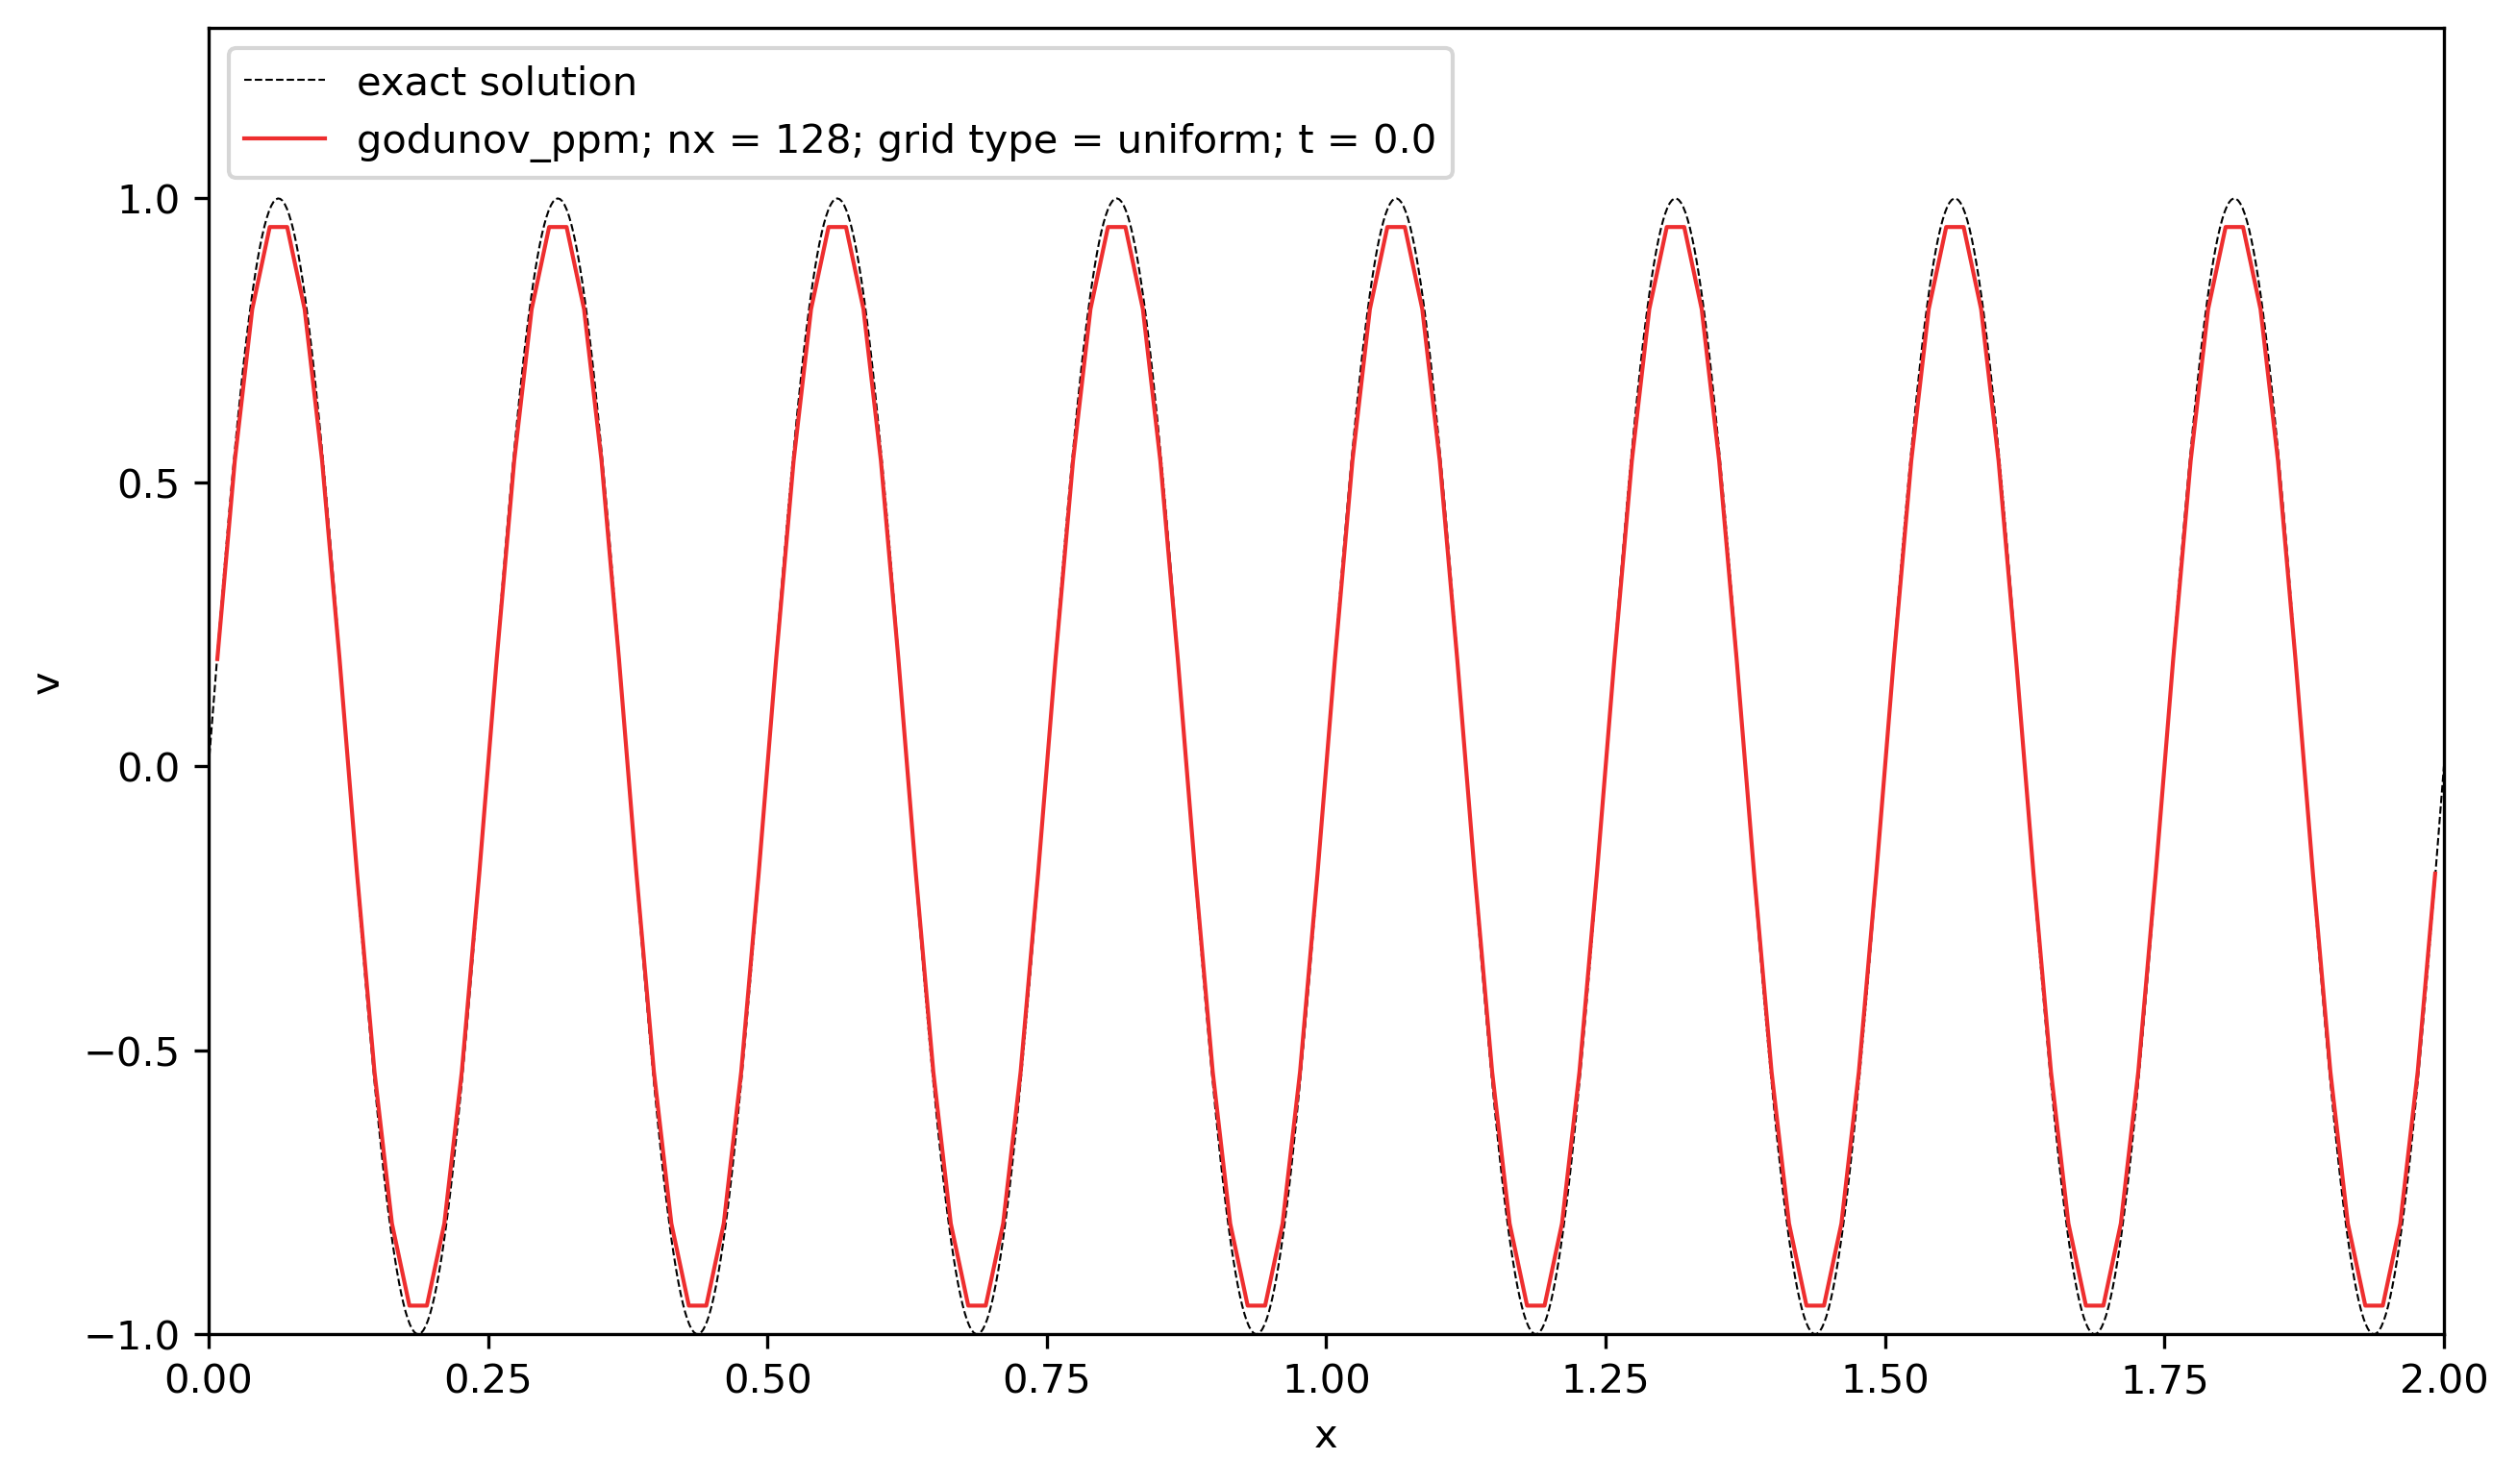

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 2, num=1000)
v_exact = [VExact(x_i,1.0,0.0,u0,v0,alpha,beta,A,nu) for x_i in x_exact]
ax.plot(x_exact,v_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_,_ = postprocess_dist('8pi',0,root_dir,['godunov_ppm'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,2])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('v')

fig.savefig('12a-ctv_uniform_final_godunov_ppm_initial.png',dpi=300)

### Animated to show dissipation

In [88]:
plt.rcParams["animation.html"] = "jshtml"
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['godunov_ppm'],['uniform'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)

def animate(i):
    _,_,_,ds = postprocess_dist('8pi',i,root_dir,['godunov_ppm'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],False,2)
    sliceplot._switch_ds(ds)
    ax.axhline(0,0,1,color="red",linewidth=3)

    return 

# FuncAnimation(fig, animate, frames=len(plt_files), interval=200)
anim = FuncAnimation(fig, animate, frames=9, interval=200)
anim.save('11b-ctv_uniform_final_godunov_ppm_initial_slice.gif',dpi=300)

yt : [INFO     ] 2022-08-07 21:15:42,528 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:15:42,530 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:15:42,538 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:15:42,546 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:43,741 xlim = 0.000000 2.0

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:45,404 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:47,076 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:51,289 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:54,443 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:15:59,140 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:04,059 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:08,110 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:15,036 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:20,892 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:26,097 Making a fixed reso

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:16:30,555 Making a fixed reso

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-08 08:10:22,917 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-08 08:10:22,921 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-08 08:10:22,929 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-08 08:10:22,933 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:24,608 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:26,322 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:27,558 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:28,870 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:29,954 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:31,006 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:32,012 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:10:33,082 Parameters: current

/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


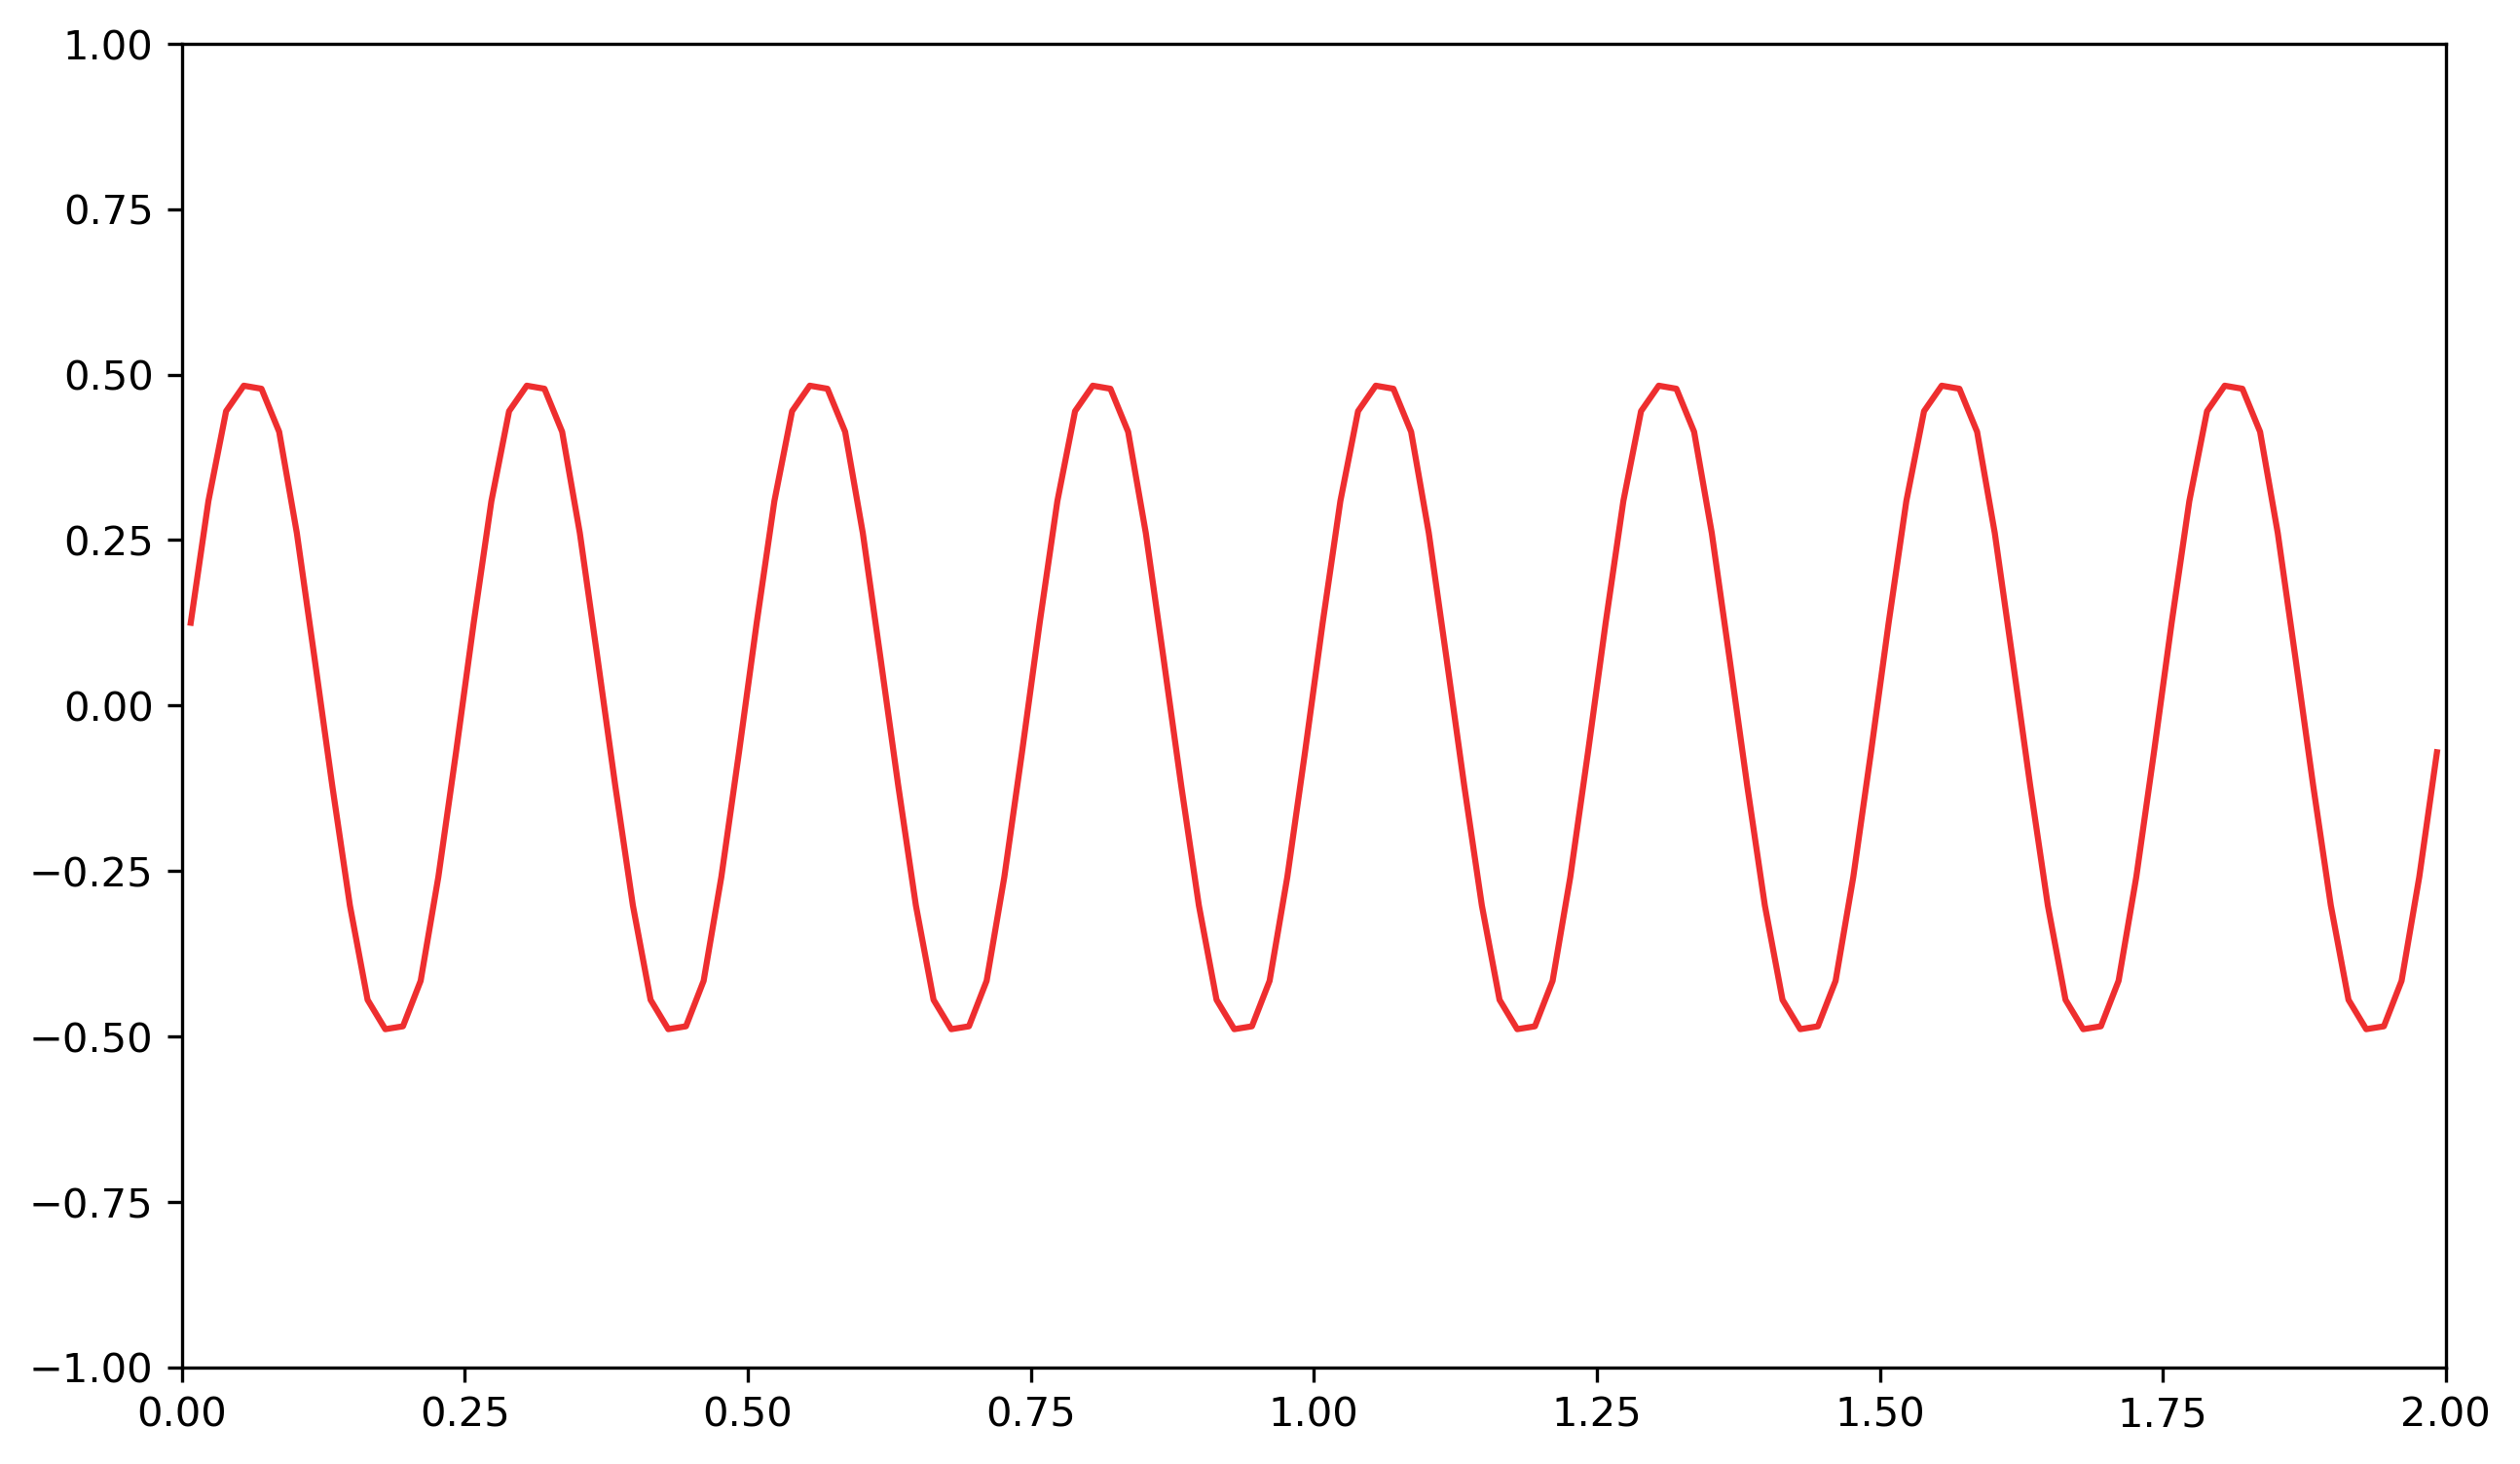

In [119]:
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 2), ylim=(-1, 1))
line, = ax.plot([], [], color=color_list[0])

def init():
    line.set_data([], [])
    return line,
def animate(i):
    _,x,y,_ = postprocess_dist('8pi',i,root_dir,['godunov_ppm'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],False,2)
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=9, interval=200, blit=True)
anim.save('12b-ctv_uniform_final_godunov_ppm_initial.gif',dpi=300)

### Compare methods at final timestep

In [90]:
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['godunov_weno_z'],['uniform'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('11c-ctv_uniform_final_godunov_weno_z_final_slice.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:17:20,468 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:17:20,471 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:17:20,475 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:17:20,478 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:21,643 xlim = 0.000000 2.0

yt : [INFO     ] 2022-08-07 21:17:24,333 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:17:24,335 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:17:24,345 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:17:24,351 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:25,303 Parameters: current

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:26,511 Parameters: current

/Users/dbeckers/ctv/mol_central/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


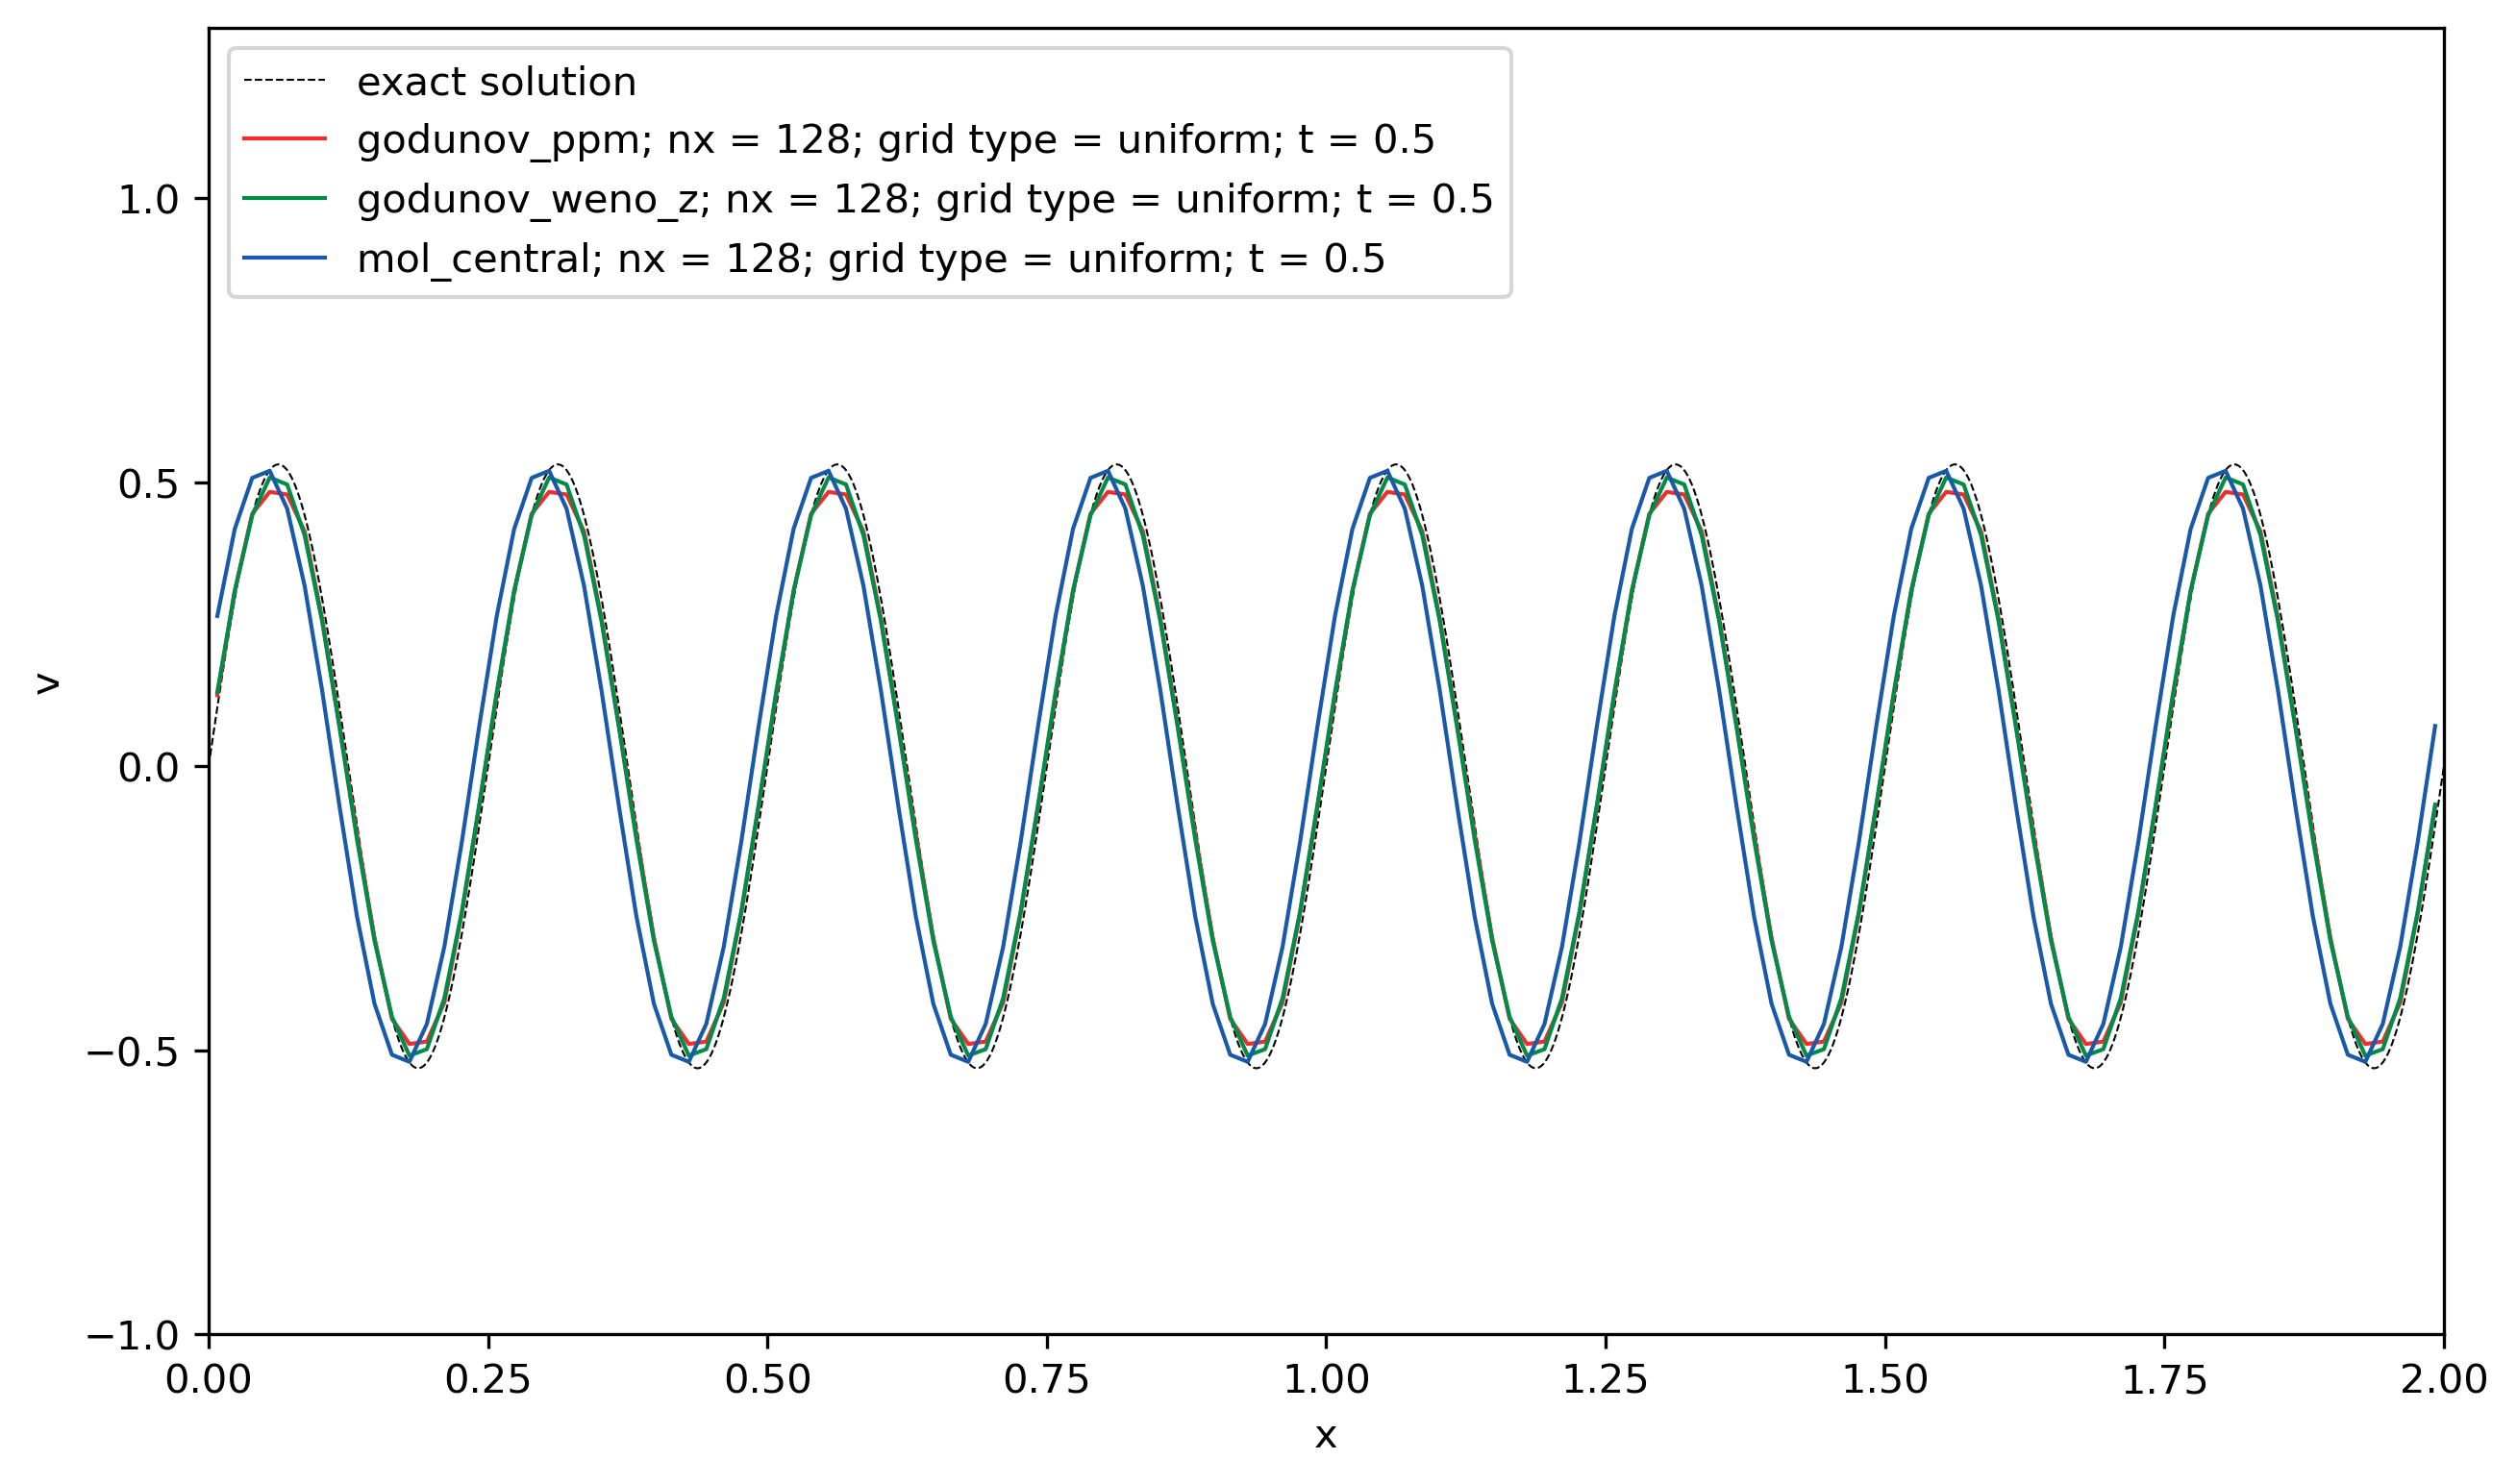

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 2, num=1000)
v_exact = [VExact(x_i,1.0,0.5,u0,v0,alpha,beta,A,nu) for x_i in x_exact]
ax.plot(x_exact,v_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_,_ = postprocess_dist('8pi',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,2])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('v')

fig.savefig('12c-ctv_uniform_final_godunov_ppm_weno_z_mol_central.png',dpi=300)

### Zoom

In [92]:
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['godunov_weno_z'],['uniform'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0.5,0.625,color="red",linewidth=3)
fig.savefig('11d-ctv_uniform_final_godunov_weno_z_final_slice_zoom.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:17:28,746 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:17:28,748 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:17:28,757 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:17:28,769 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:30,084 xlim = 0.000000 2.0

yt : [INFO     ] 2022-08-07 21:17:32,702 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 21:17:32,706 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2022-08-07 21:17:32,711 Parameters: domain_left_edge          = [ 0.         0.        -0.0078125]
yt : [INFO     ] 2022-08-07 21:17:32,714 Parameters: domain_right_edge         = [2.        2.        0.0078125]


/Users/dbeckers/ctv/godunov_ppm/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:33,780 Parameters: current

/Users/dbeckers/ctv/godunov_weno_z/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:34,910 Parameters: current

/Users/dbeckers/ctv/mol_central/uniform/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


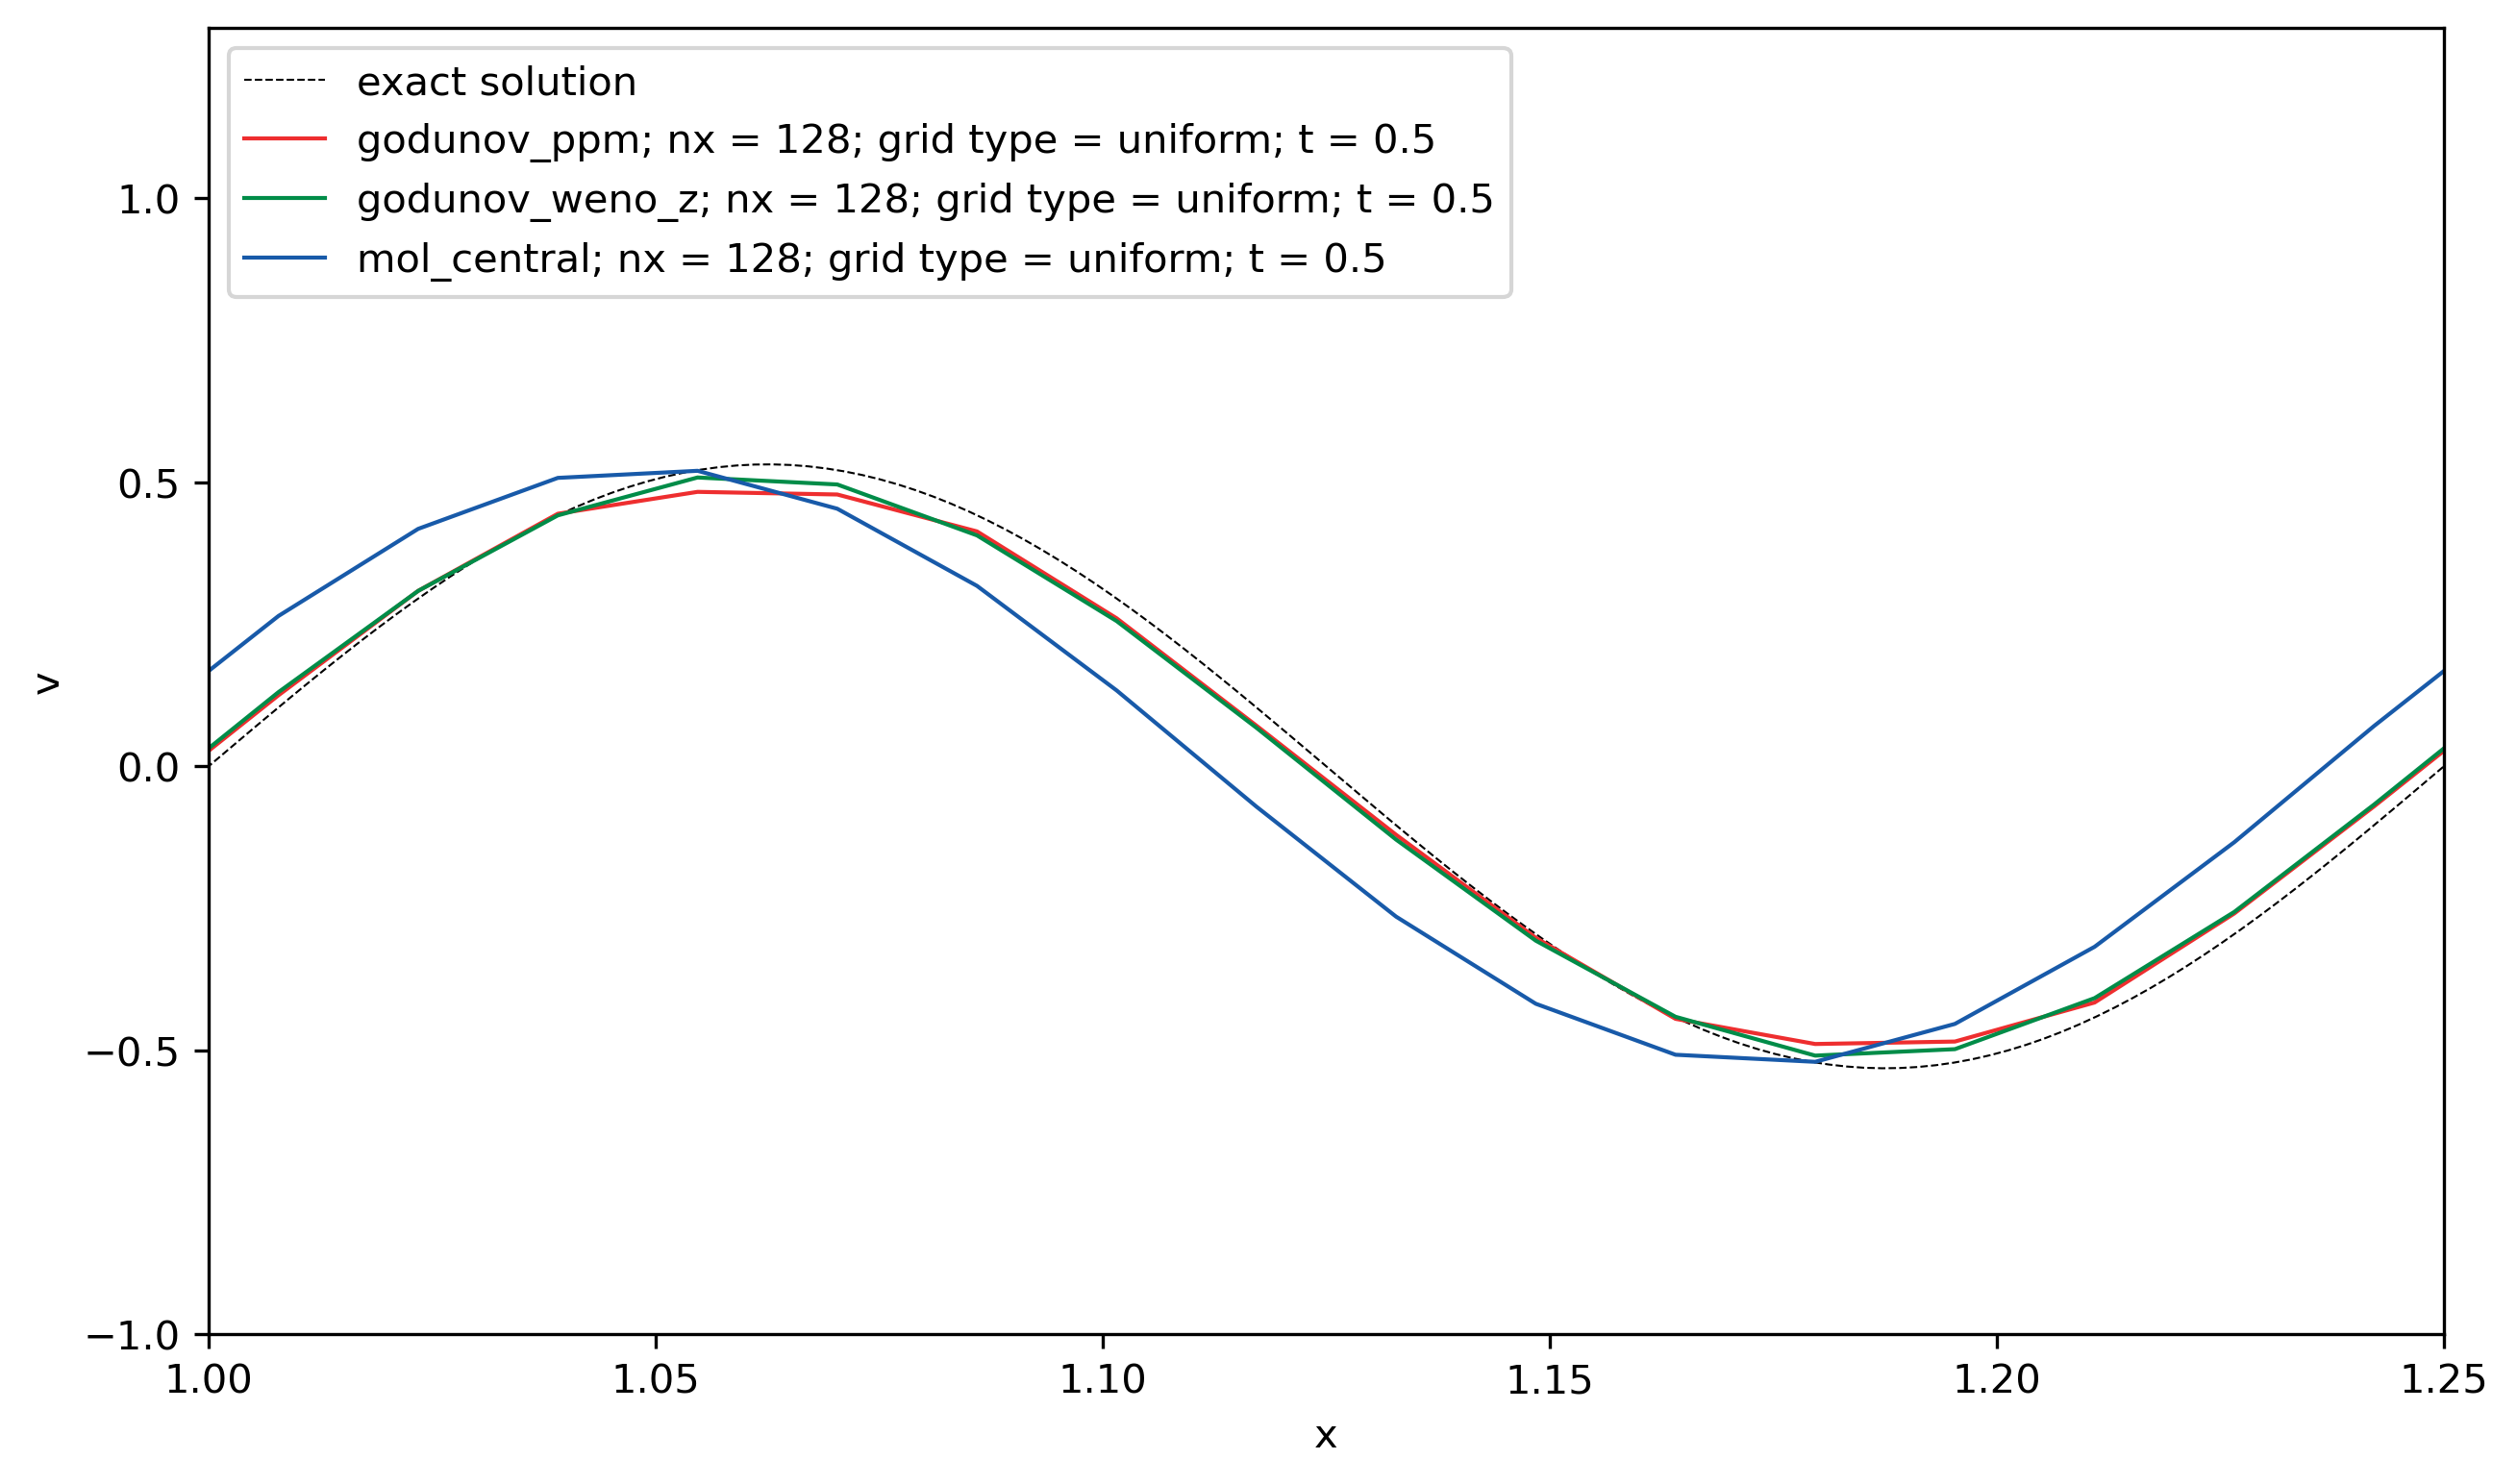

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 2, num=1000)
v_exact = [VExact(x_i,1.0,0.5,u0,v0,alpha,beta,A,nu) for x_i in x_exact]
ax.plot(x_exact,v_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_,_ = postprocess_dist('8pi',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([1,1.25])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('v')

fig.savefig('12d-ctv_uniform_final_godunov_ppm_weno_z_mol_central_zoom.png',dpi=300)

### Refined

In [94]:
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['godunov_weno_z'],['fine_to_coarse'],[64],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('13a-ctv_refined_final_godunov_weno_z_slice.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:17:36,695 Parameters: current_time              = 1.0018984374999962
yt : [INFO     ] 2022-08-07 21:17:36,697 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:17:36,705 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:17:36,716 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/godunov_weno_z/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:38,382 xlim = 0.000000 2.0

yt : [INFO     ] 2022-08-07 21:17:41,176 Parameters: current_time              = 1.0018984374999962
yt : [INFO     ] 2022-08-07 21:17:41,179 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:17:41,193 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:17:41,195 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/godunov_ppm/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:42,593 Parameters: current

/Users/dbeckers/ctv/godunov_weno_z/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:17:43,691 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


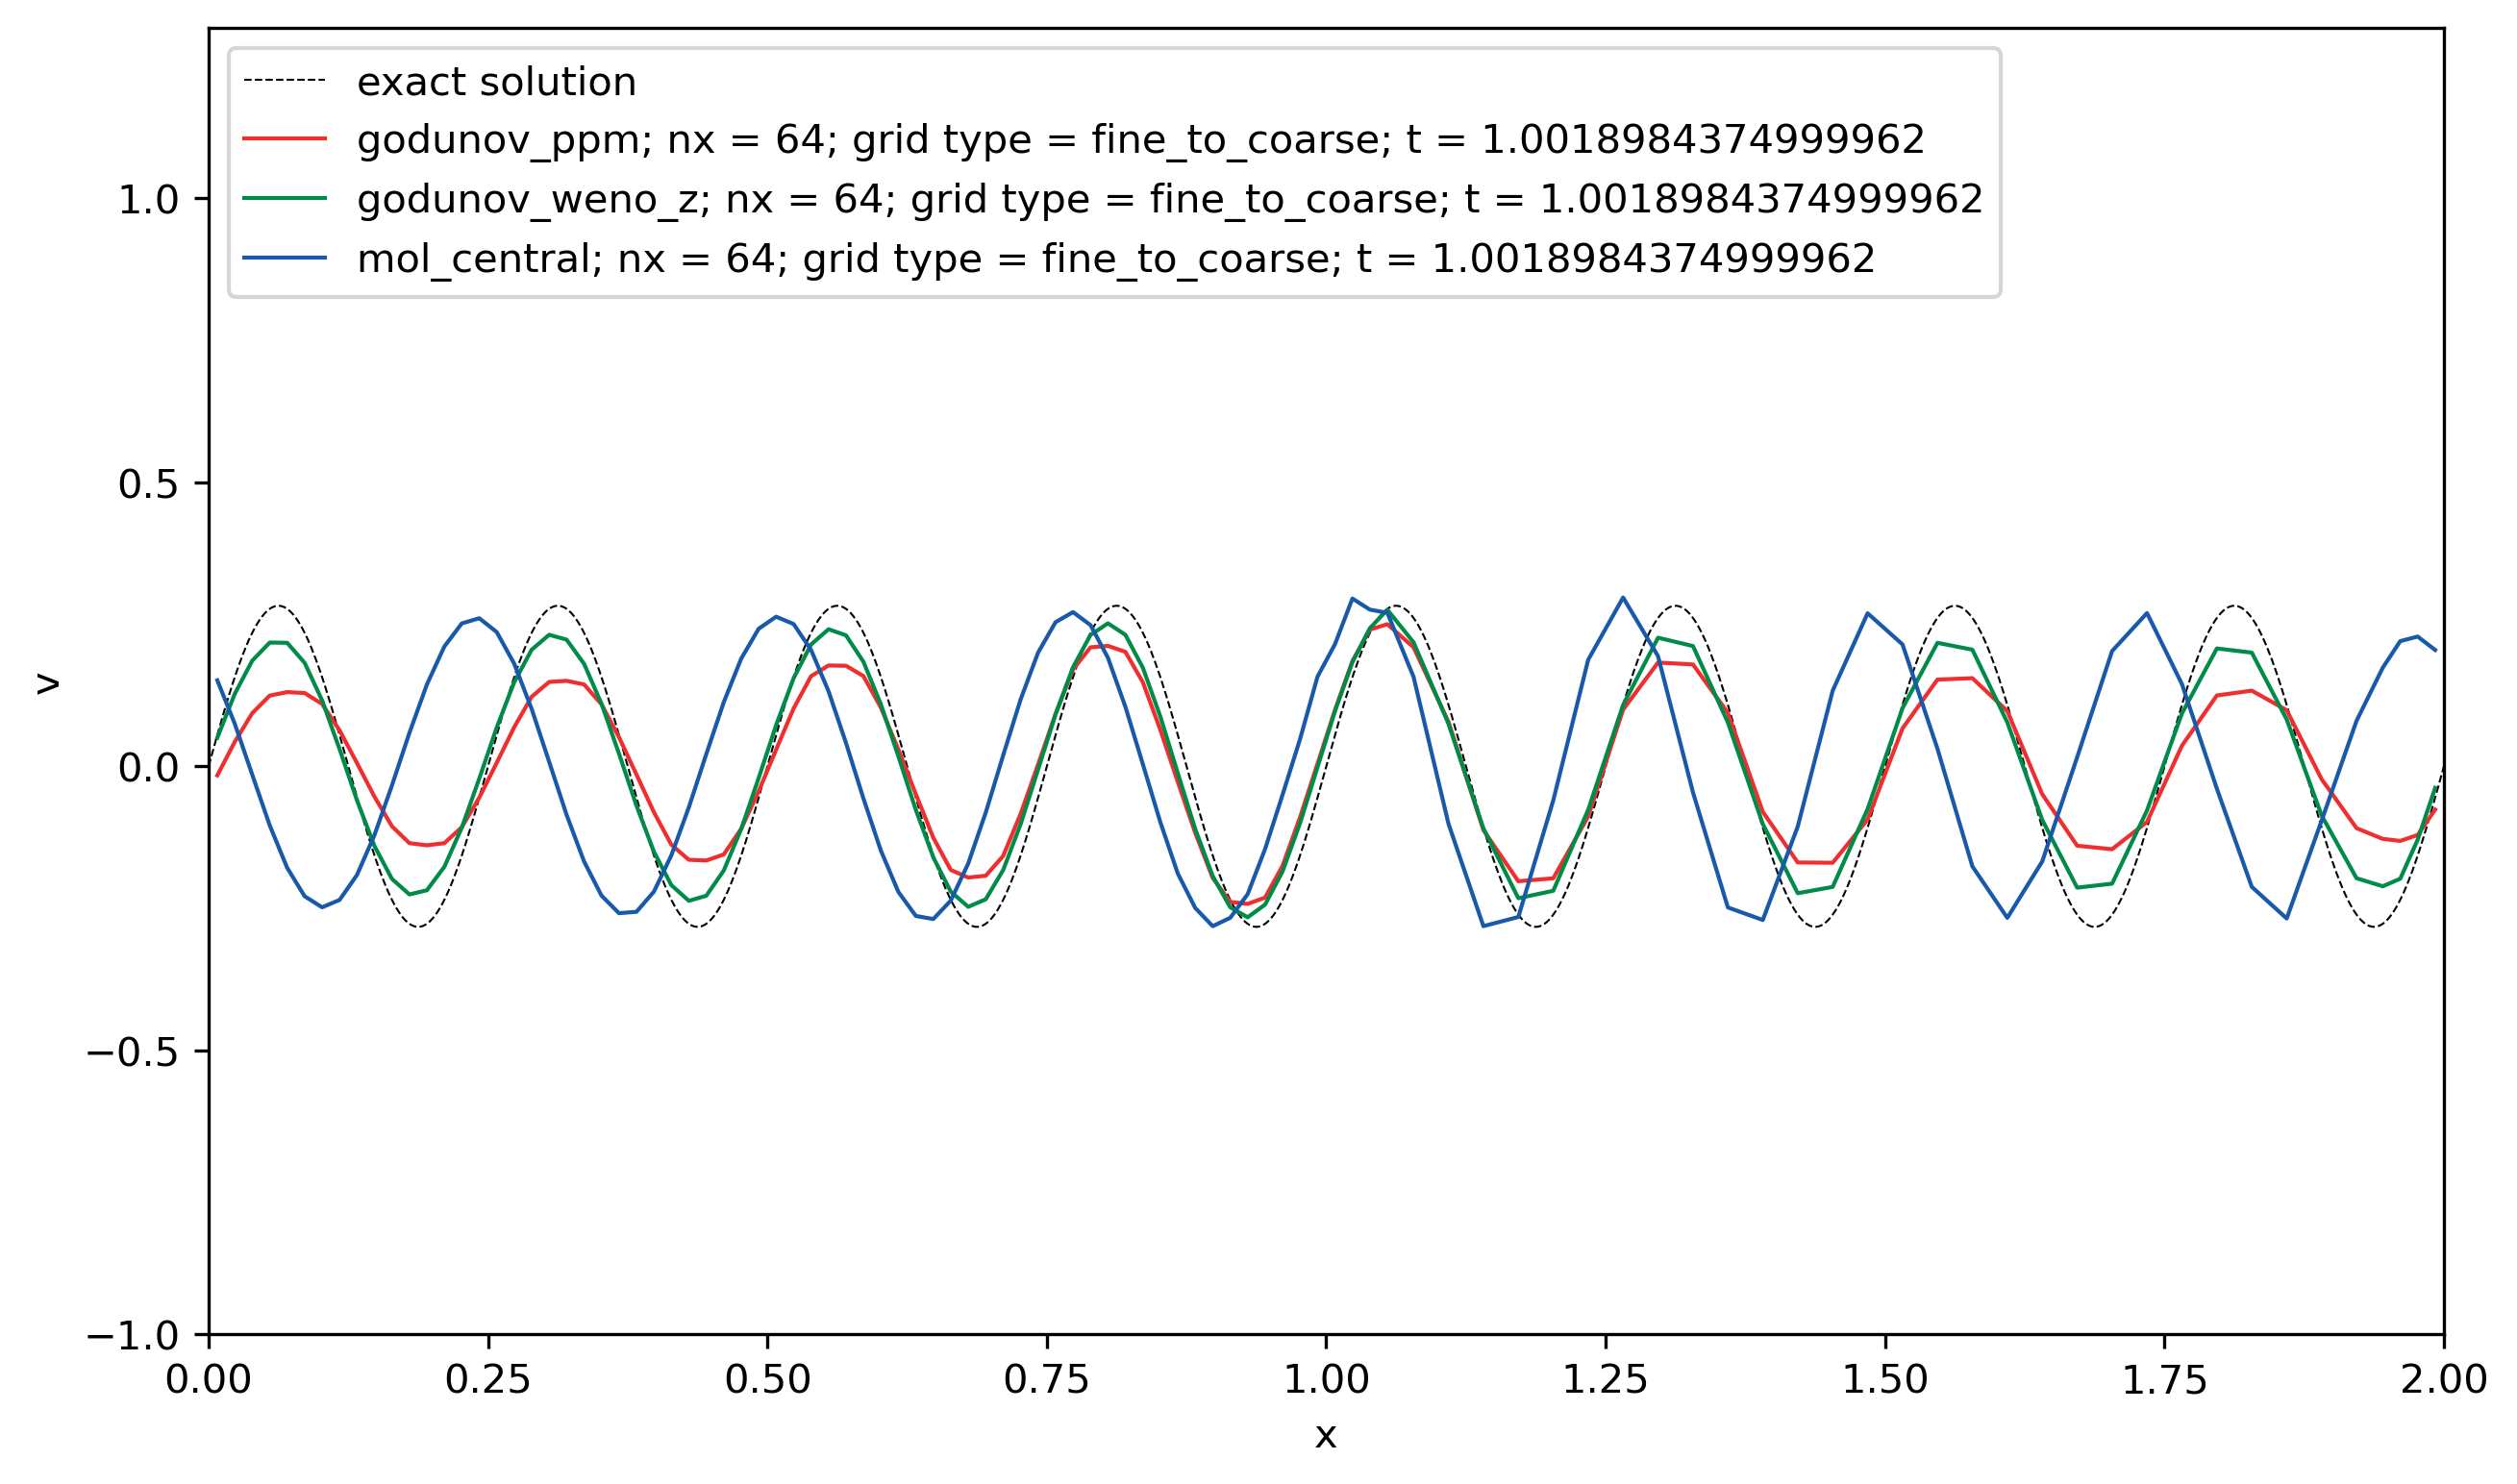

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 2, num=1000)
v_exact = [VExact(x_i,1.0,1.0,u0,v0,alpha,beta,A,nu) for x_i in x_exact]
ax.plot(x_exact,v_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_,_ = postprocess_dist('8pi',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[64],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,2])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('v')

fig.savefig('14a-ctv_refined_final_godunov_ppm_weno_z_mol_central.png',dpi=300)

### Specifically looking at mol central

In [99]:
plt.rcParams["animation.html"] = "jshtml"
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['mol_central'],['fine_to_coarse'],[64],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)

def animate(i):
    print(i)
    _,_,_,ds = postprocess_dist('8pi',i,root_dir,['mol_central'],['fine_to_coarse'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    sliceplot._switch_ds(ds)
    ax.axhline(0,0,1,color="red",linewidth=3)

    return 

# FuncAnimation(fig, animate, frames=len(plt_files), interval=200)
anim = FuncAnimation(fig, animate, frames=10, interval=200)
anim.save('13b-ctv_refined_mol_central_slice.gif',dpi=300)

yt : [INFO     ] 2022-08-07 21:27:34,309 Parameters: current_time              = 1.0018984374999962
yt : [INFO     ] 2022-08-07 21:27:34,312 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:27:34,318 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:27:34,324 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:35,859 xlim = 0.000000 2.0

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:37,936 Making a fixed reso

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:39,730 Making a fixed reso

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:43,833 Making a fixed reso

1
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:47,849 Making a fixed reso

2
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:52,739 Making a fixed reso

3
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:27:58,112 Making a fixed reso

4
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:27,199 Making a fixed reso

5
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:31,699 Making a fixed reso

6
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:37,902 Making a fixed reso

7
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:43,105 Making a fixed reso

8
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:49,781 Making a fixed reso

9
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:28:55,967 Making a fixed reso

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 21:29:43,869 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:29:43,872 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:29:43,880 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:29:43,887 Parameters: domain_right_edge         = [2.     2.     0.0625]


0
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:45,399 Parameters: current

1
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:46,882 Parameters: current

2
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:48,194 Parameters: current

3
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:49,613 Parameters: current

4
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:51,010 Parameters: current

5
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:52,647 Parameters: current

6
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:54,294 Parameters: current

7
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:55,906 Parameters: current

8
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:29:57,710 Parameters: current

9
/Users/dbeckers/ctv/mol_central/fine_to_coarse/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


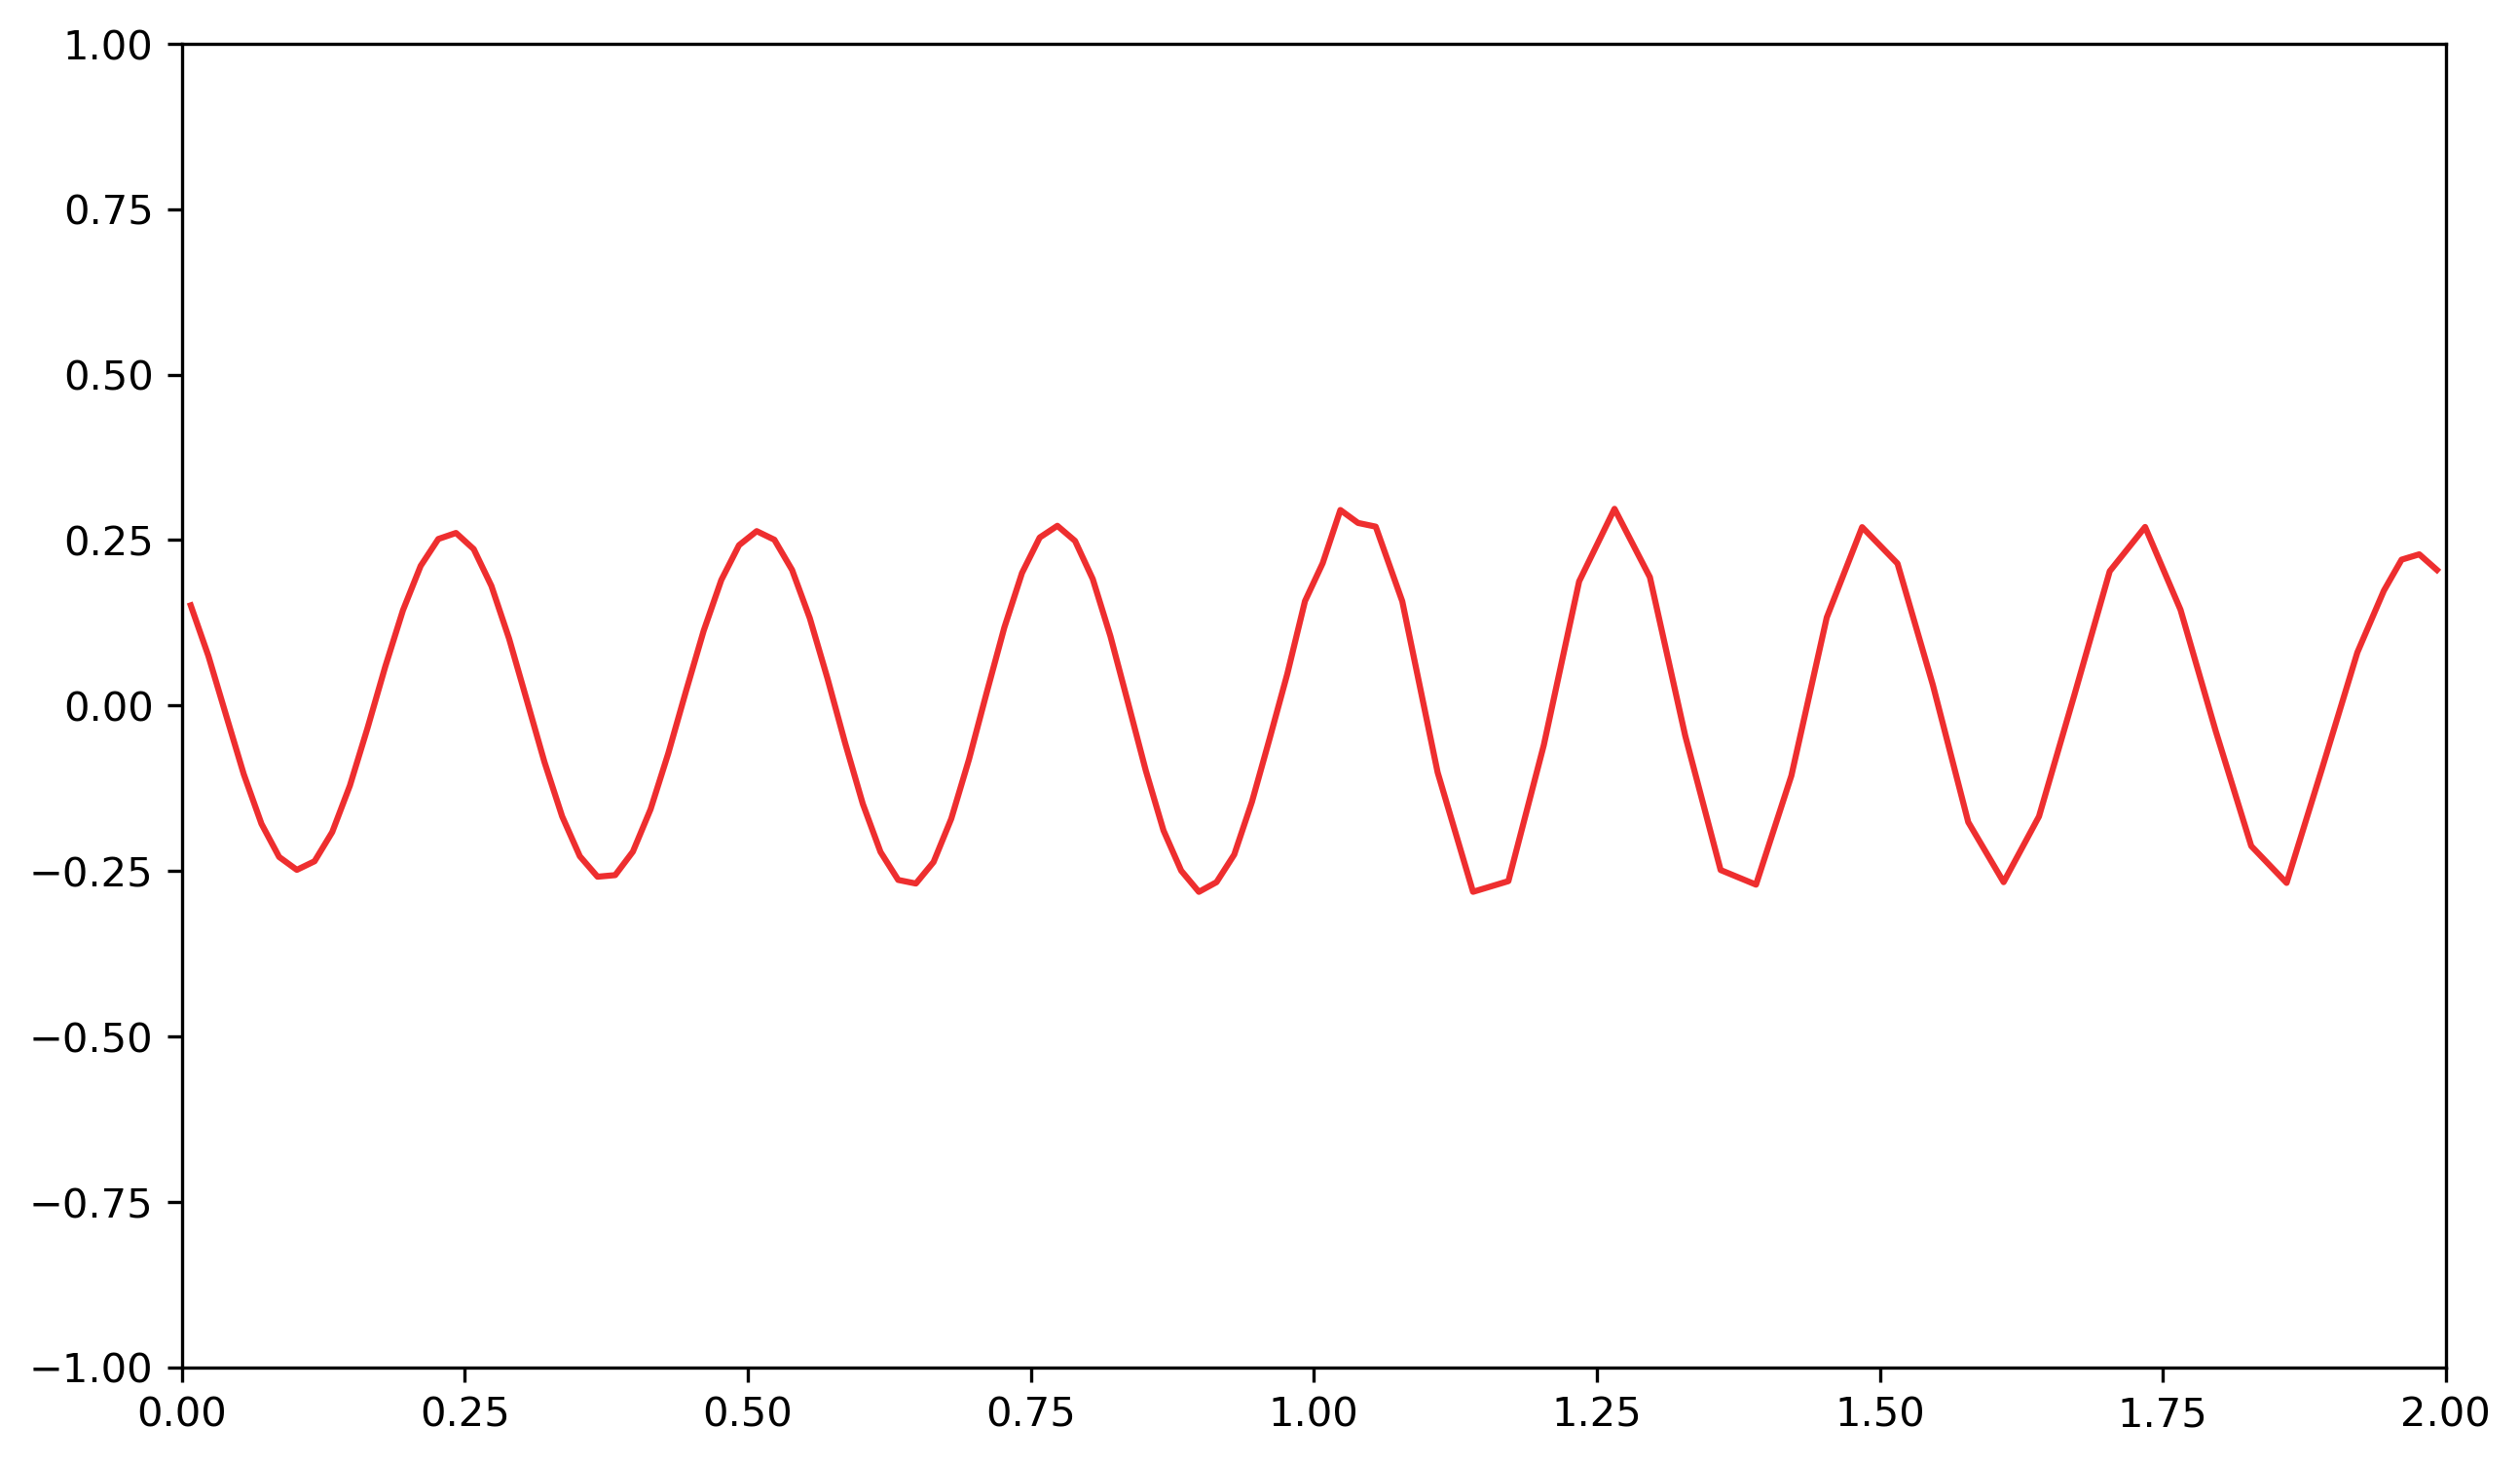

In [100]:
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 2), ylim=(-1, 1))
line, = ax.plot([], [], color=color_list[0])

def init():
    line.set_data([], [])
    return line,
def animate(i):
    print(i)
    _,x,y,_ = postprocess_dist('8pi',i,root_dir,['mol_central'],['fine_to_coarse'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=10, interval=200, blit=True)
anim.save('14b-ctv_refined_final_mol_central.gif',dpi=300)

# Modulate with Gaussian

## Viscosity = 1e-3

In [105]:
_,_,_,ds = postprocess_dist('8pi',0,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('15a-ctv_refined_modulated_1e-3_final_mol_central_slice_initial.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:32:16,590 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:32:16,592 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:32:16,600 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:32:16,603 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:32:18,137 xlim = 0.000000 2.0

yt : [INFO     ] 2022-08-07 21:32:27,820 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:32:27,823 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:32:27,827 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:32:27,833 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


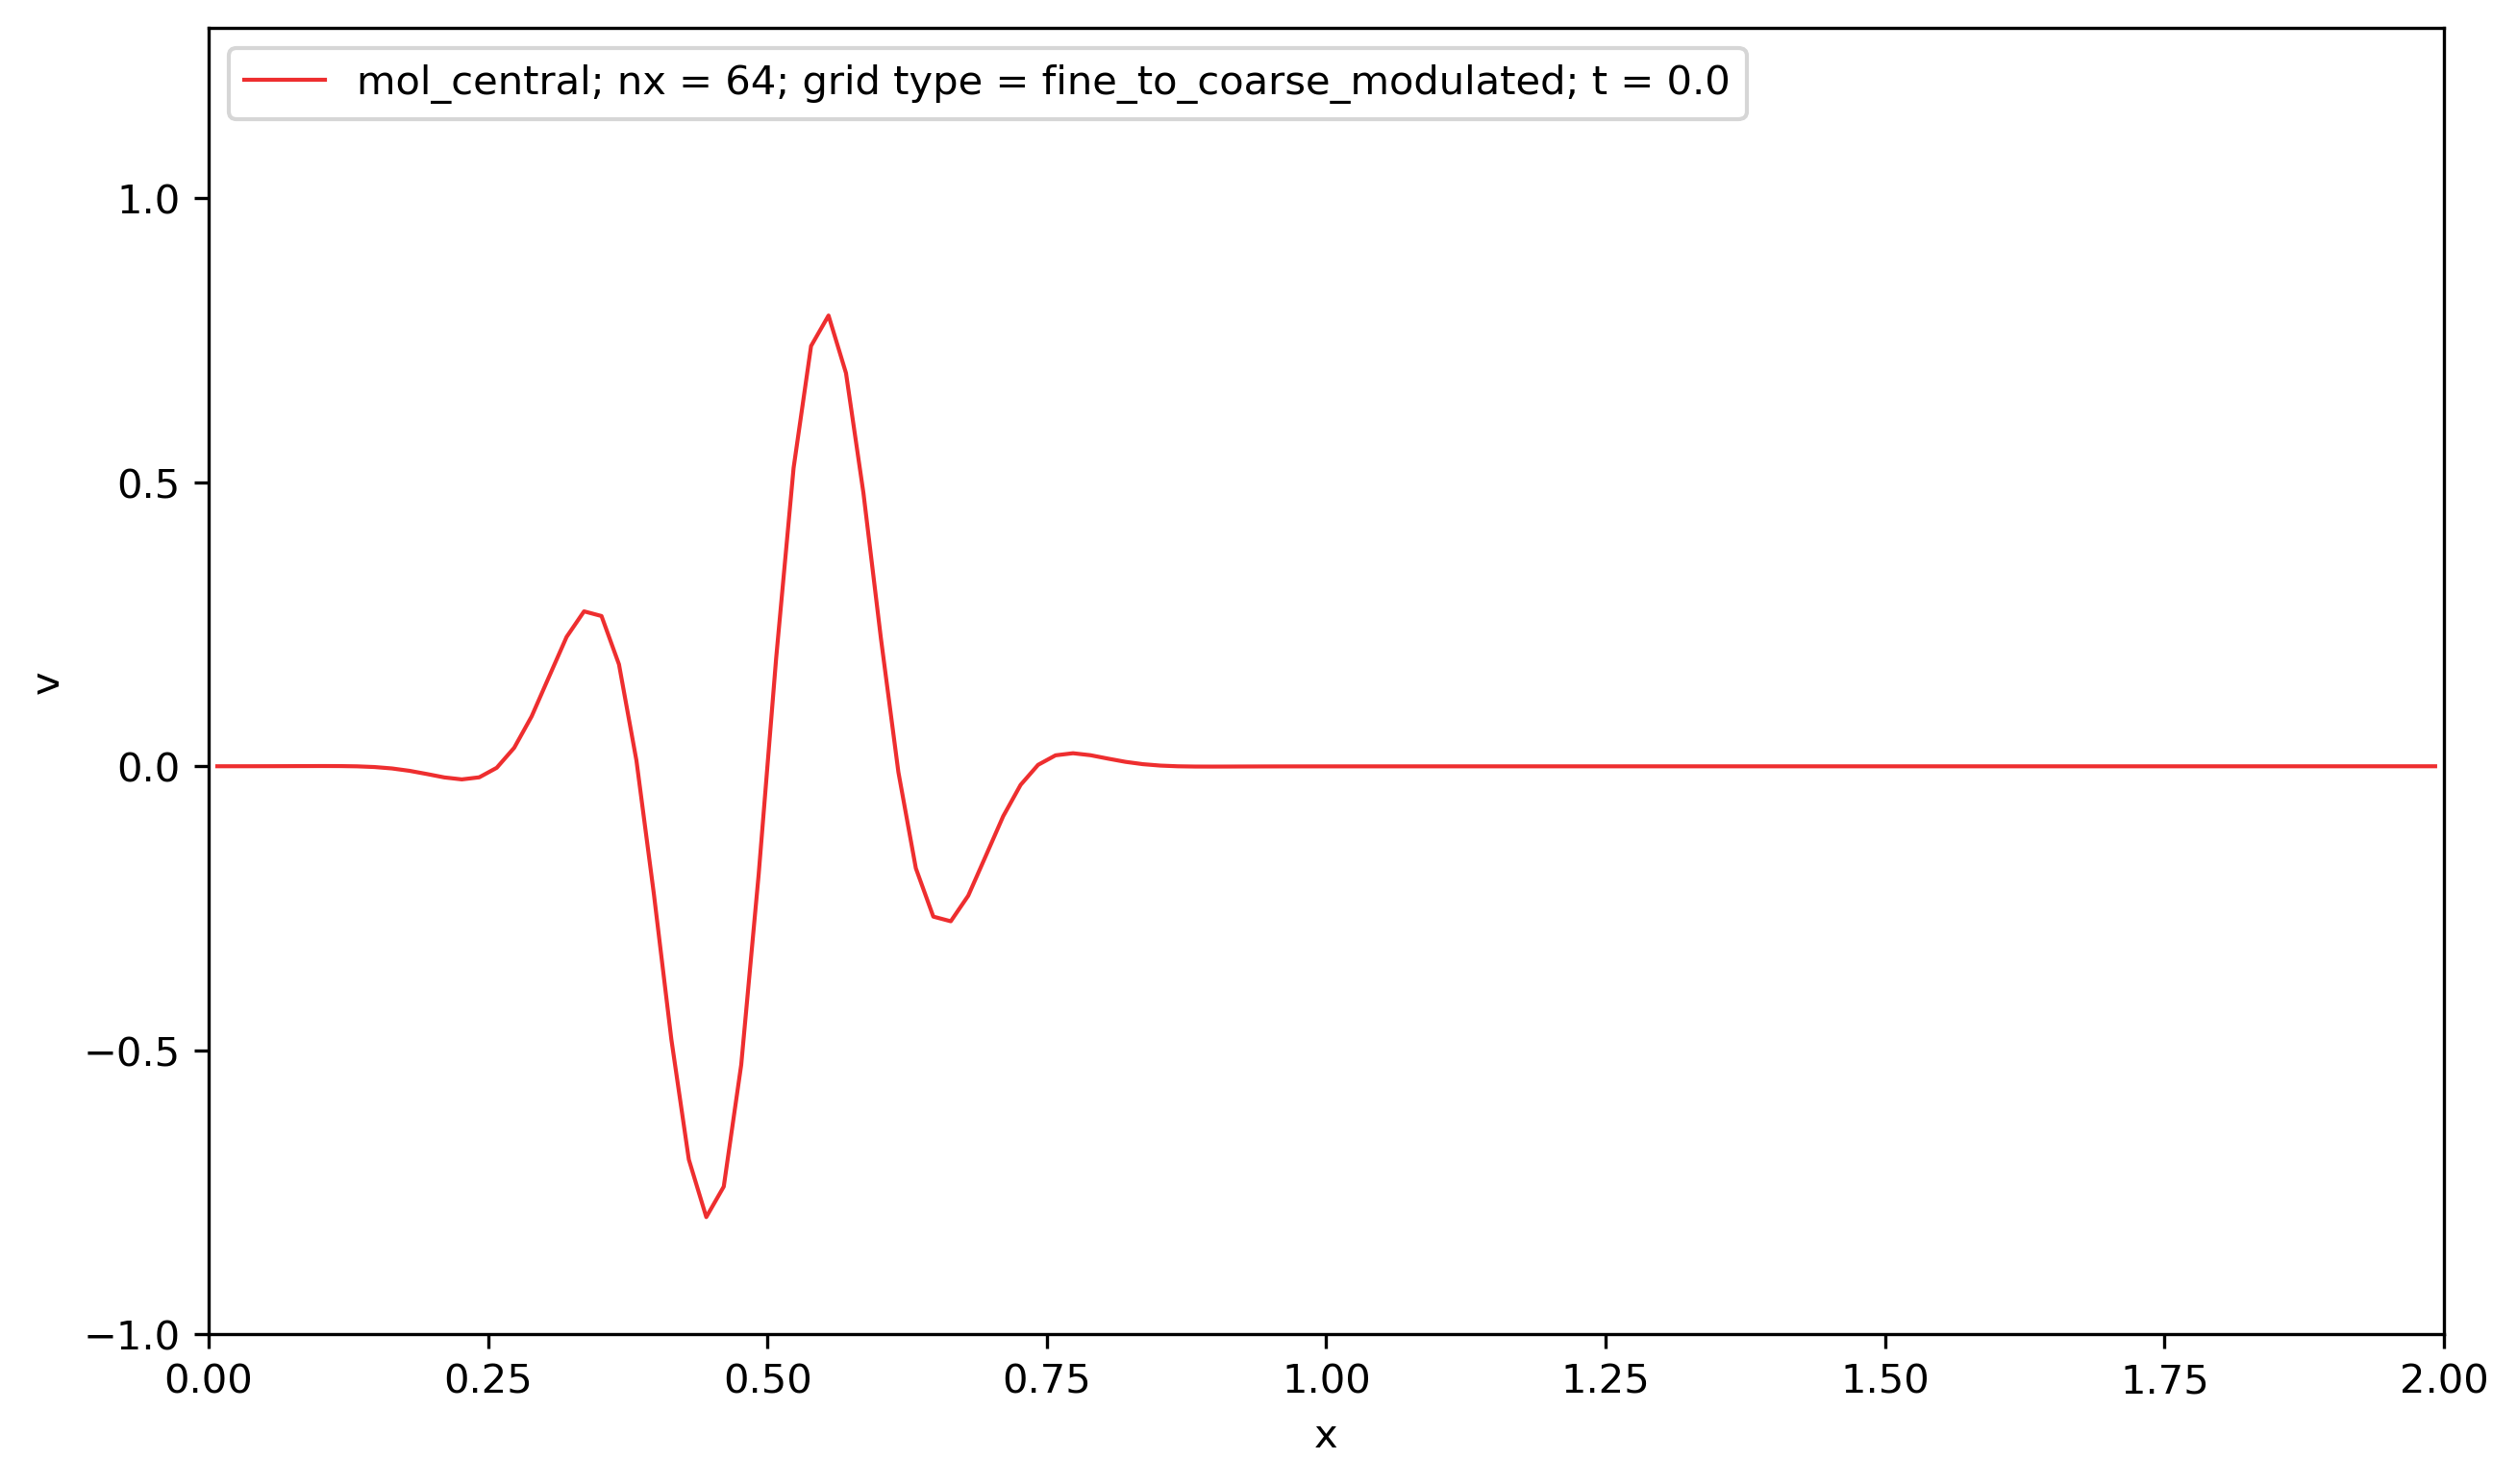

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))

t,_,_,_ = postprocess_dist('8pi',0,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,2])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('v')

fig.savefig('16a-ctv_refined_modulated_1e-3_final_mol_central_initial.png',dpi=300)

#### Final

In [124]:
_,_,_,ds = postprocess_dist('8pi',10,root_dir,['mol_central'],['fine_to_coarse_modulated'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('15a2-ctv_refined_modulated_1e-3_final_mol_central_slice_final.png',dpi=300)

yt : [INFO     ] 2022-08-08 08:50:59,825 Parameters: current_time              = 1.2449999999999877
yt : [INFO     ] 2022-08-08 08:50:59,827 Parameters: domain_dimensions         = [128 128   4]
yt : [INFO     ] 2022-08-08 08:50:59,835 Parameters: domain_left_edge          = [ 0.       0.      -0.03125]
yt : [INFO     ] 2022-08-08 08:50:59,840 Parameters: domain_right_edge         = [2.      2.      0.03125]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:51:05,945 xlim = 0.000000 2.0

#### animated

In [112]:
plt.rcParams["animation.html"] = "jshtml"
_,_,_,ds = postprocess_dist('8pi',-1,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)

def animate(i):
    _,_,_,ds = postprocess_dist('8pi',i,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    sliceplot._switch_ds(ds)
    ax.axhline(0,0,1,color="red",linewidth=3)

    return 

# FuncAnimation(fig, animate, frames=len(plt_files), interval=200)
anim = FuncAnimation(fig, animate, frames=18, interval=200)
anim.save('15b-ctv_refined_modulated_1e-3_final_mol_central_slice.gif',dpi=300)

yt : [INFO     ] 2022-08-07 21:41:54,536 Parameters: current_time              = 2.0036718749999847
yt : [INFO     ] 2022-08-07 21:41:54,541 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:41:54,546 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:41:54,551 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:41:56,188 xlim = 0.000000 2.0

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:41:58,066 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:41:59,605 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:02,526 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:30,620 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:34,919 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:39,148 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:44,113 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:49,698 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:42:55,636 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:01,231 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:06,159 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:10,891 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:17,235 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:22,649 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:27,509 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:33,172 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:38,668 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:43,661 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:48,312 Making a fixed reso

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:43:53,521 Making a fixed reso

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 21:44:03,957 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:44:03,960 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:44:03,963 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:44:03,968 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:06,002 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:07,531 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:08,795 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:10,060 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:11,654 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:13,323 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:14,827 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:16,332 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:17,833 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:19,193 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:20,720 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:22,675 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:24,160 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:25,614 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:27,303 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:29,070 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:44:30,692 Parameters: current

/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


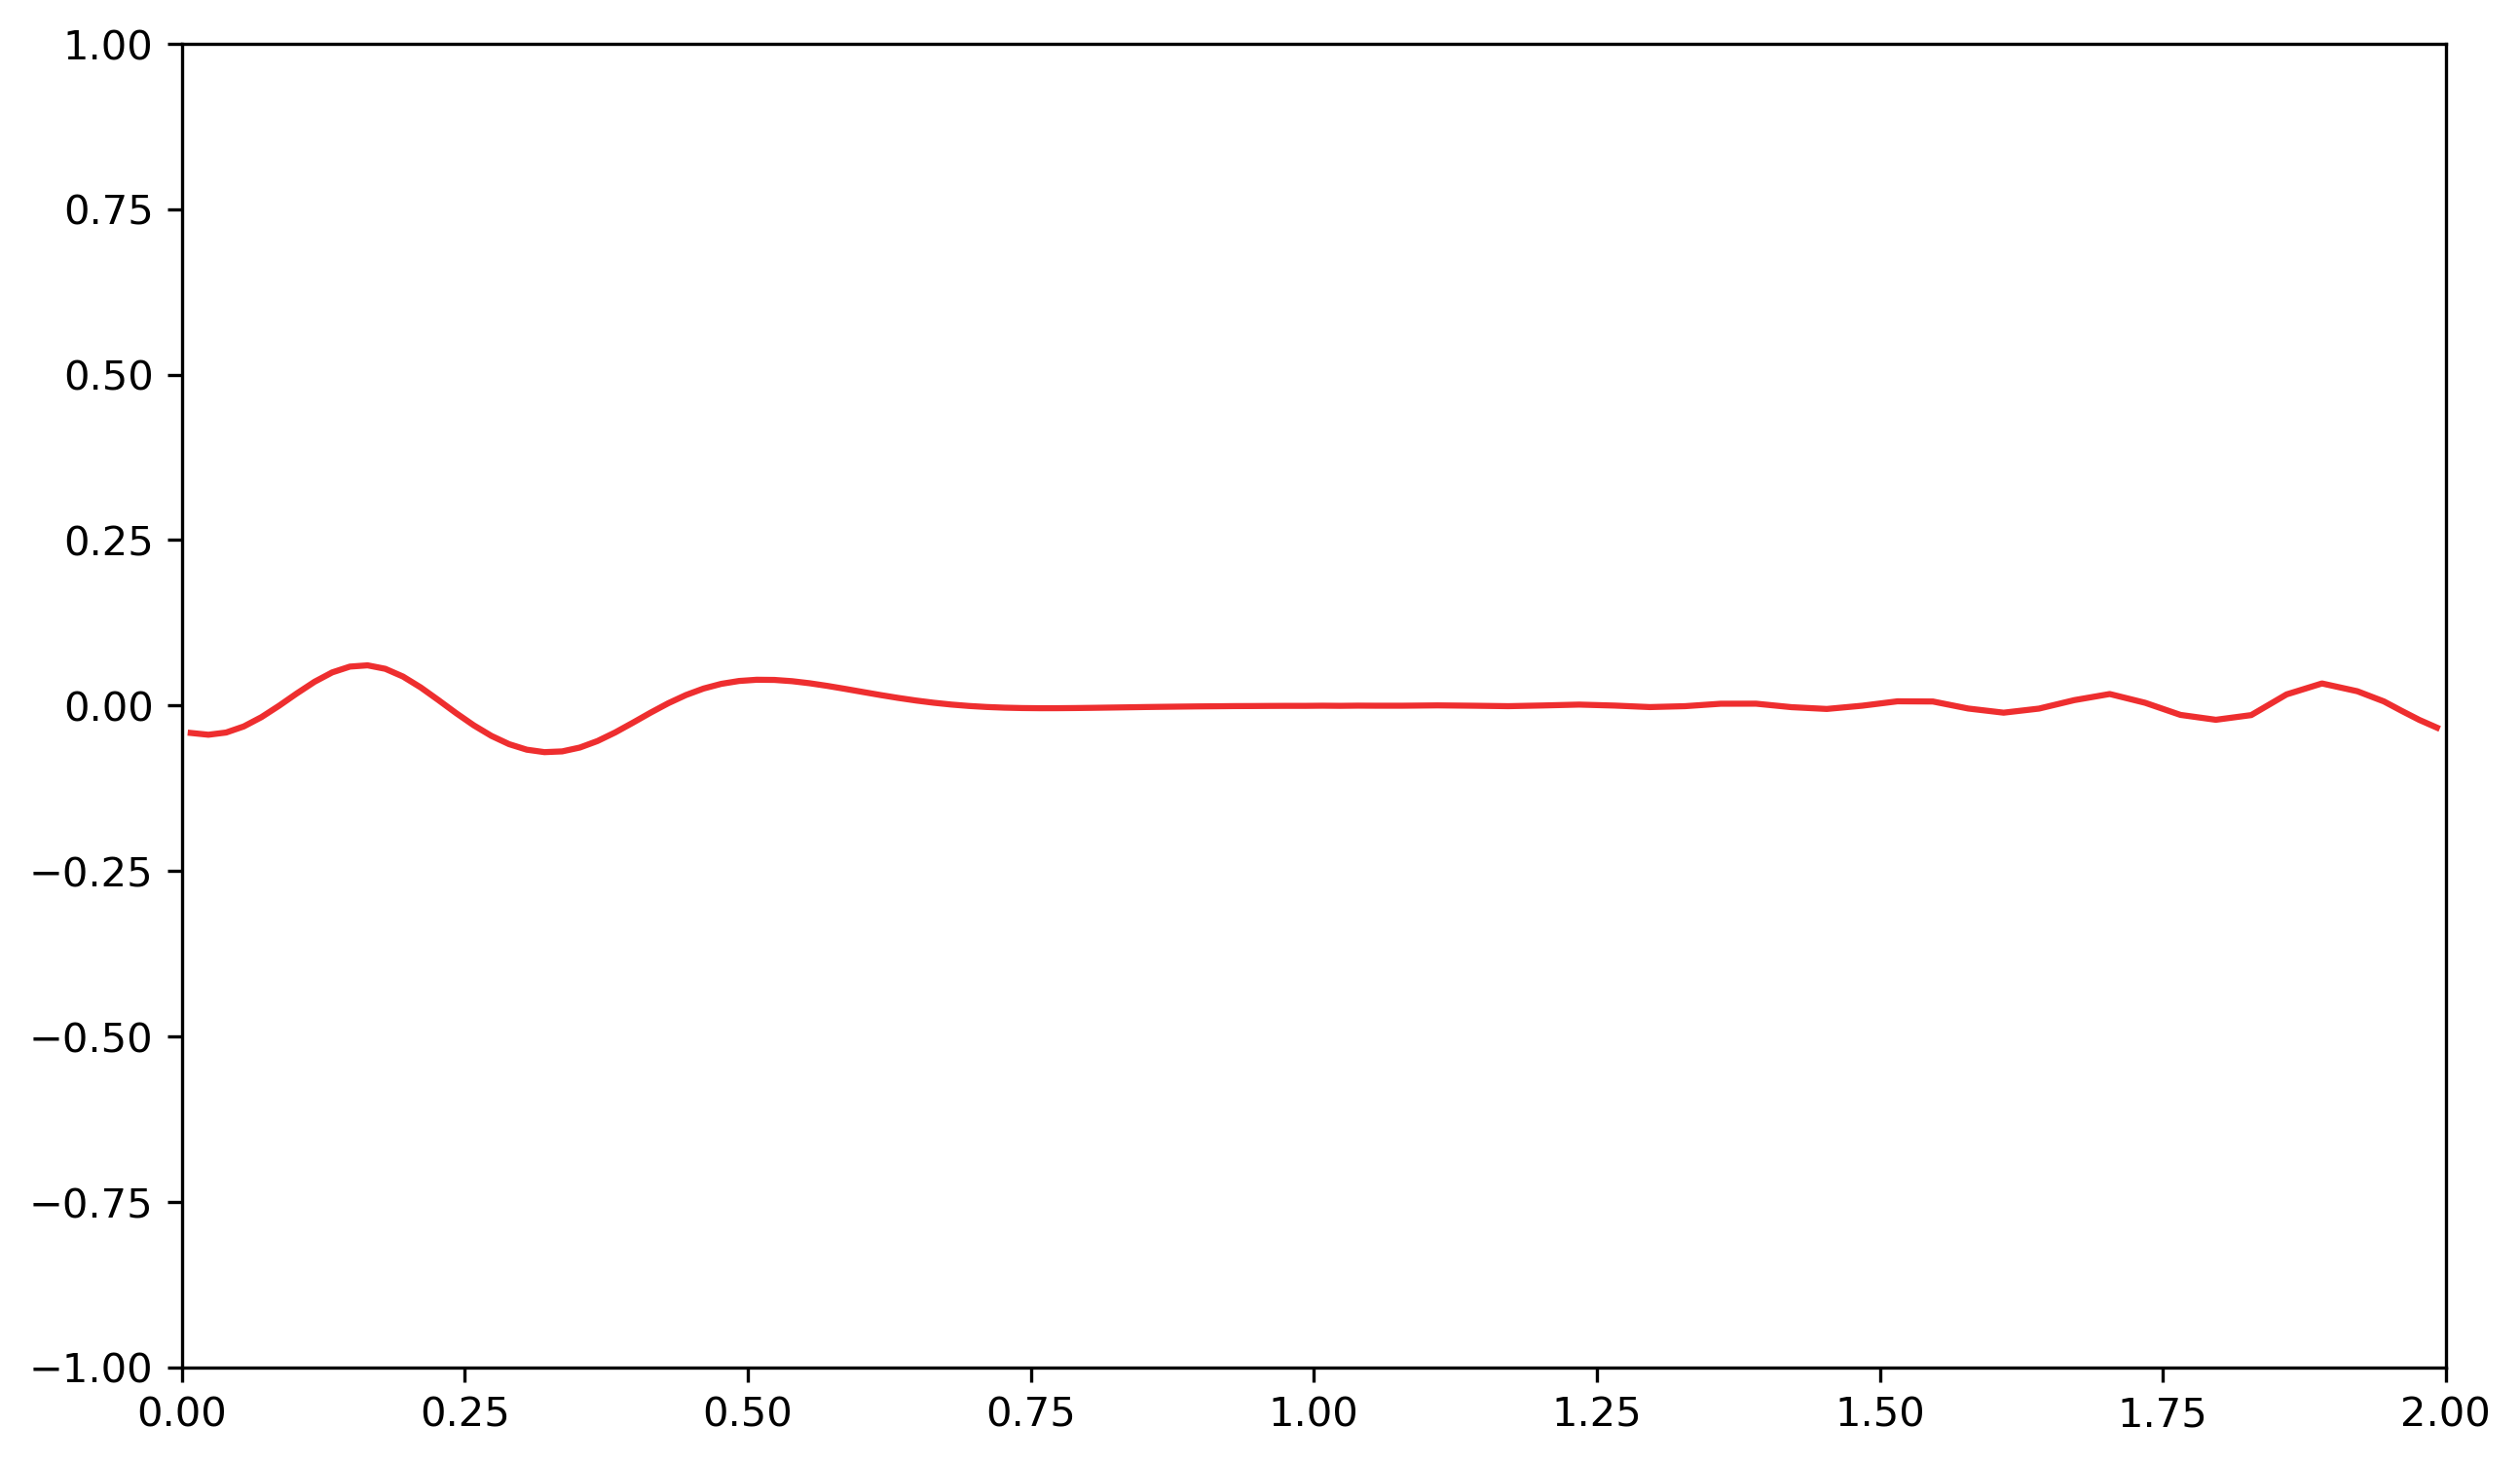

In [113]:
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 2), ylim=(-1, 1))
line, = ax.plot([], [], color=color_list[0])

def init():
    line.set_data([], [])
    return line,
def animate(i):
    _,x,y,_ = postprocess_dist('8pi',i,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=18, interval=200, blit=True)
anim.save('16b-ctv_refined_modulated_1e-3_final_mol_central.gif',dpi=300)

## Viscosity = 1e-4

In [118]:
plt.rcParams["animation.html"] = "jshtml"
_,_,_,ds = postprocess_dist('8pi_1e-4',-1,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
# sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)

def animate(i):
    print(i)
    _,_,_,ds = postprocess_dist('8pi_1e-4',i,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    sliceplot._switch_ds(ds)
    ax.axhline(0,0,1,color="red",linewidth=3)

    return 

# FuncAnimation(fig, animate, frames=len(plt_files), interval=200)
anim = FuncAnimation(fig, animate, frames=30, interval=200)
anim.save('15c-ctv_refined_modulated_1e-4_final_mol_central_slice.gif',dpi=300)

yt : [INFO     ] 2022-08-07 21:50:25,314 Parameters: current_time              = 2.000351562499961
yt : [INFO     ] 2022-08-07 21:50:25,315 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:50:25,323 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:50:25,333 Parameters: domain_right_edge         = [2.     2.     0.0625]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:50:26,708 xlim = 0.000000 2.0

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:50:28,799 Making a fixed reso

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:50:30,347 Making a fixed reso

0
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:50:34,234 Making a fixed reso

1
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:50:37,849 Making a fixed reso

2
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:28,191 Making a fixed reso

3
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:33,660 Making a fixed reso

4
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:38,390 Making a fixed reso

5
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:43,198 Making a fixed reso

6
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:47,777 Making a fixed reso

7
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:51:54,114 Making a fixed reso

8
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:52:00,531 Making a fixed reso

9
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:52:07,161 Making a fixed reso

10
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:52:12,713 Making a fixed reso

11
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:52:23,242 Making a fixed reso

12
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:52:33,929 Making a fixed reso

13
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


yt : [INFO     ] 2022-08-07 21:52:39,795 Parameters: domain_right_edge         = [2.     2.     0.0625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1

14
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


yt : [INFO     ] 2022-08-07 21:52:49,203 Parameters: current_time              = 0.8742999999999909
yt : [INFO     ] 2022-08-07 21:52:49,234 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:52:49,237 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:52:49,256 Parameters: domain_right_edge         = [2.     2.     0.0625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDepr

15
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


yt : [INFO     ] 2022-08-07 21:53:02,530 Parameters: current_time              = 0.9367499999999892
yt : [INFO     ] 2022-08-07 21:53:02,664 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:53:02,809 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:53:02,866 Parameters: domain_right_edge         = [2.     2.     0.0625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDepr

16
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:18,573 Making a fixed reso

17
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:29,238 Making a fixed reso

18
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:33,756 Making a fixed reso

19
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:38,233 Making a fixed reso

20
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:43,874 Making a fixed reso

21
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:49,656 Making a fixed reso

22
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:53:55,124 Making a fixed reso

23
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:00,134 Making a fixed reso

24
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:05,753 Making a fixed reso

25
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:11,253 Making a fixed reso

26
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:17,213 Making a fixed reso

27
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:22,038 Making a fixed reso

28
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:26,907 Making a fixed reso

29
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:54:34,496 Making a fixed reso

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 21:48:05,815 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 21:48:05,817 Parameters: domain_dimensions         = [64 64  4]
yt : [INFO     ] 2022-08-07 21:48:05,823 Parameters: domain_left_edge          = [ 0.      0.     -0.0625]
yt : [INFO     ] 2022-08-07 21:48:05,829 Parameters: domain_right_edge         = [2.     2.     0.0625]


0
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:07,096 Parameters: current

1
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:08,319 Parameters: current

2
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:09,534 Parameters: current

3
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:10,788 Parameters: current

4
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:12,889 Parameters: current

5
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:14,855 Parameters: current

6
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:16,269 Parameters: current

7
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:17,922 Parameters: current

8
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:19,523 Parameters: current

9
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:21,255 Parameters: current

10
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:22,527 Parameters: current

11
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:23,723 Parameters: current

12
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:24,941 Parameters: current

13
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:26,161 Parameters: current

14
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:27,383 Parameters: current

15
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:28,624 Parameters: current

16
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:29,875 Parameters: current

17
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:31,152 Parameters: current

18
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:32,469 Parameters: current

19
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:33,713 Parameters: current

20
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:34,953 Parameters: current

21
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:36,186 Parameters: current

22
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:37,432 Parameters: current

23
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:38,638 Parameters: current

24
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:39,854 Parameters: current

25
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:41,103 Parameters: current

26
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:42,351 Parameters: current

27
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:43,565 Parameters: current

28
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-07 21:48:44,775 Parameters: current

29
/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_64


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


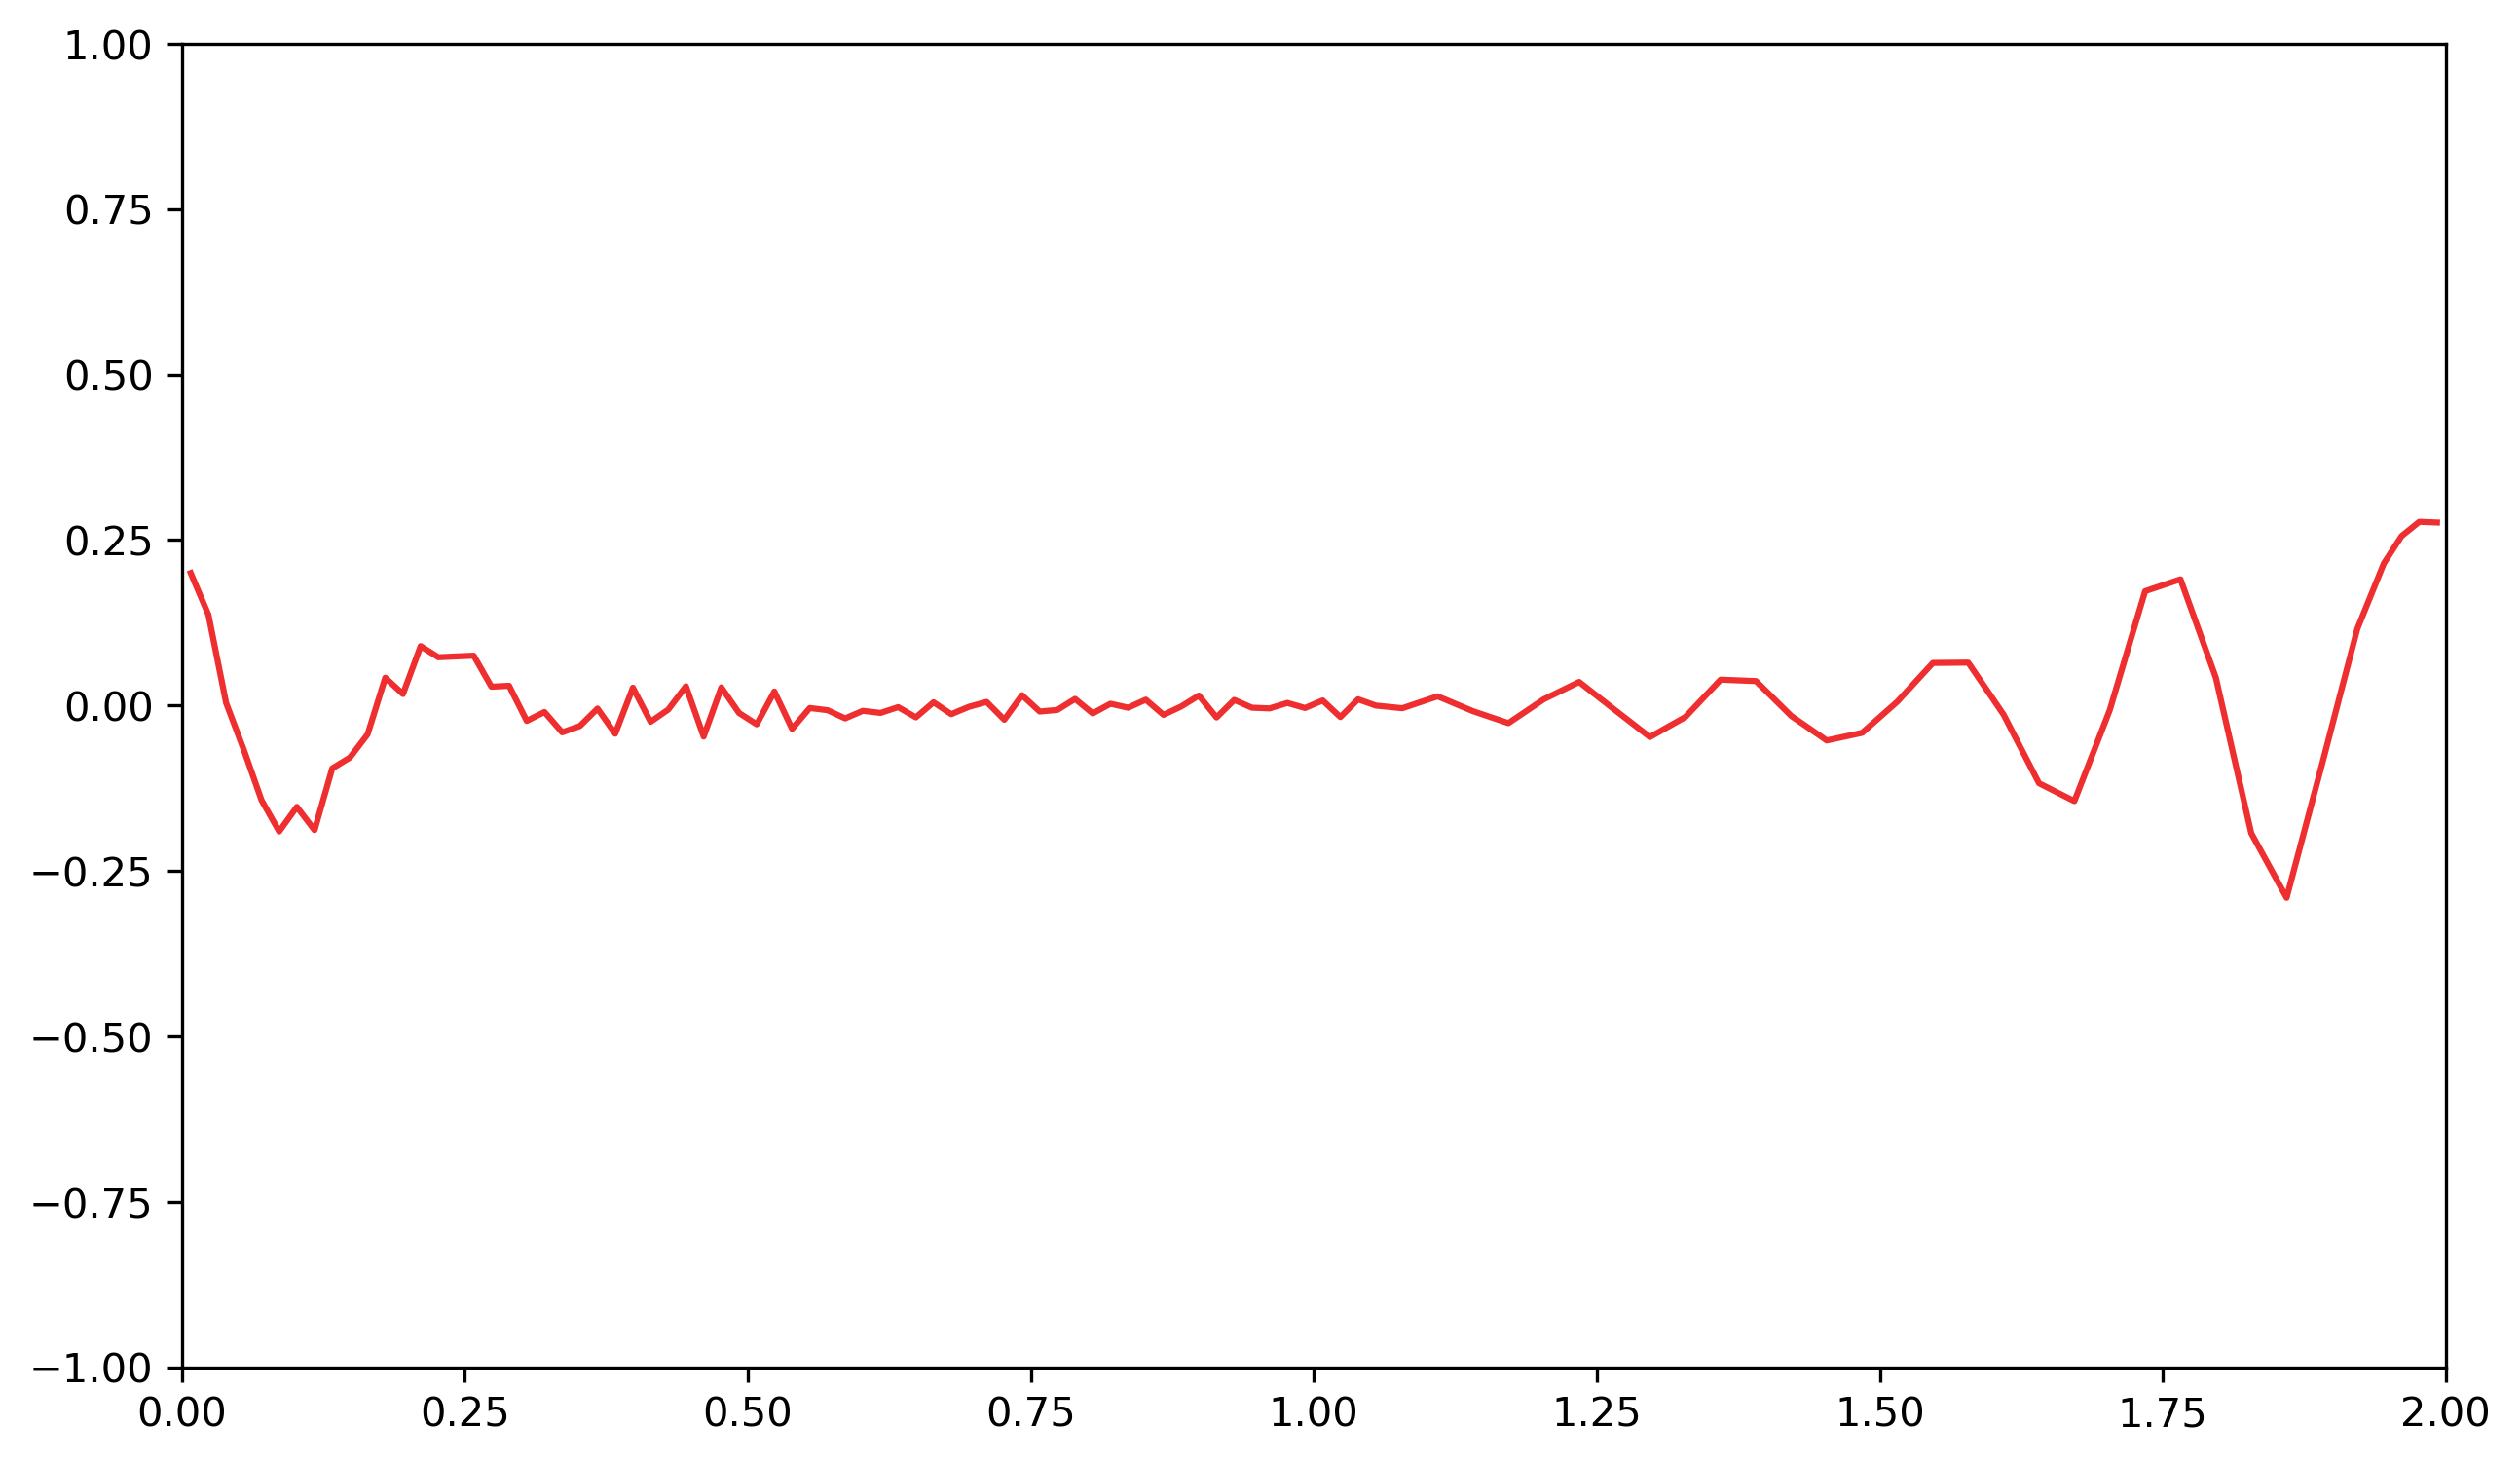

In [117]:
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 2), ylim=(-1, 1))
line, = ax.plot([], [], color=color_list[0])

def init():
    line.set_data([], [])
    return line,
def animate(i):
    print(i)
    _,x,y,_ = postprocess_dist('8pi_1e-4',i,root_dir,['mol_central'],['fine_to_coarse_modulated'],[64],
                 ax,linestyle_list,color_list,[1.0],False,2)
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=30, interval=200, blit=True)
anim.save('16c-ctv_refined_modulated_1e-4_final_mol_central.gif',dpi=300)

In [130]:
_,_,_,ds = postprocess_dist('8pi_1e-4',15,root_dir,['mol_central'],['fine_to_coarse_modulated'],[128],
                 _,linestyle_list,color_list,[1.0],False,2)
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
sliceplot.set_zlim(("velocityy"), -1, 1)
sliceplot.set_log(("velocityy"), True, symlog_auto=True)
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)
fig.savefig('15c2-ctv_refined_modulated_1e-4_final_mol_central_slice_final.png',dpi=300)

yt : [INFO     ] 2022-08-08 08:53:53,960 Parameters: current_time              = 0.9367499519999926
yt : [INFO     ] 2022-08-08 08:53:53,962 Parameters: domain_dimensions         = [128 128   4]
yt : [INFO     ] 2022-08-08 08:53:53,966 Parameters: domain_left_edge          = [ 0.       0.      -0.03125]
yt : [INFO     ] 2022-08-08 08:53:53,989 Parameters: domain_right_edge         = [2.      2.      0.03125]


/Users/dbeckers/ctv/mol_central/fine_to_coarse_modulated/8pi_1e-4/nx_128


/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("index", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-08-08 08:53:58,716 xlim = 0.000000 2.0

In [ ]:
anim

In [ ]:
sliceplot = yt.SlicePlot(ds, "z", ("velocityy"))
fig = sliceplot.plots[("velocityy")].figure
ax = sliceplot.plots[("velocityy")].axes
ax.axhline(0,0,1,color="red",linewidth=3)

In [ ]:
fig